# Extensometer Crack Monitoring and Landslide Prediction System

This notebook implements an ultra-advanced crack monitoring and landslide prediction system using extensometer data. The system analyzes crack opening patterns, rates, and accelerations to predict potential landslide events with high accuracy.

## System Components
1. Data Collection and Management (Extensometer Readings)
2. Advanced Data Preprocessing and Feature Engineering
3. Exploratory Data Analysis with Visualization
4. Statistical Analysis and Pattern Recognition
5. Machine Learning Models (Classification & Regression)
6. 3D Spatial Analysis
7. Real-time Alert System
8. Comprehensive Reporting

## Data Fields
- **timestamp**: Date and time of measurement
- **crack_opening**: Current crack width/displacement (mm)
- **crack_rate**: Rate of crack opening (mm/day)
- **cumulative_crack_opening**: Total accumulated displacement (mm)
- **crack_acceleration**: Rate of change in crack rate (mm/day²)
- **temperature_correction**: Temperature-corrected displacement (mm)
- **point_coordinates**: 3D location of measurement point (x, y, z)
- **risk_class**: Risk assessment (Low, Medium, High)

## 1. Setup and Required Libraries

Import necessary libraries and set up the environment for extensometer data processing and analysis.

In [19]:
# Import required libraries
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats, signal
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, f1_score, r2_score, 
                            confusion_matrix, classification_report,
                            mean_squared_error, mean_absolute_error)
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.backends.backend_pdf import PdfPages
import joblib
import warnings
import json
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define base directory structure
BASE_DIR = r"c:\Users\rkste\Desktop\AI Rockfall Prediction"
DATA_DIR = os.path.join(BASE_DIR, "Data")
UPLOAD_DIR = os.path.join(BASE_DIR, "Upload")

# Extensometer-specific directories
EXTENSOMETER_DIR = os.path.join(UPLOAD_DIR, "Extensometer")
IMAGES_DIR = os.path.join(EXTENSOMETER_DIR, "images")
ANALYSIS_DIR = os.path.join(EXTENSOMETER_DIR, "Analysis")
REPORT_DIR = os.path.join(EXTENSOMETER_DIR, "Report")
THREED_DIR = os.path.join(EXTENSOMETER_DIR, "3-D")

# Create all necessary directories
for directory in [DATA_DIR, IMAGES_DIR, ANALYSIS_DIR, REPORT_DIR, THREED_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define file paths
DATA_FILE = os.path.join(DATA_DIR, 'extensometer_data.csv')

# Non-overwrite helper function
def get_next_filename(directory, base_name, extension):
    """
    Generate next available filename with sequential numbering to avoid overwriting.
    
    Args:
        directory: Target directory path
        base_name: Base filename without extension
        extension: File extension (e.g., '.csv', '.png', '.json')
    
    Returns:
        Full path to next available filename
    
    Example:
        get_next_filename('/path', 'data', '.csv')
        -> '/path/data.csv' (if doesn't exist)
        -> '/path/data_1.csv' (if data.csv exists)
        -> '/path/data_2.csv' (if data_1.csv exists)
    """
    base_path = os.path.join(directory, f"{base_name}{extension}")
    
    # If base file doesn't exist, use it
    if not os.path.exists(base_path):
        return base_path
    
    # Find all existing numbered versions
    pattern = os.path.join(directory, f"{base_name}_*{extension}")
    existing_files = glob.glob(pattern)
    
    # If no numbered versions exist, start with _1
    if not existing_files:
        return os.path.join(directory, f"{base_name}_1{extension}")
    
    # Extract numbers from existing files and find maximum
    max_num = 0
    for file_path in existing_files:
        filename = os.path.basename(file_path)
        # Match pattern: base_name_NUMBER.extension
        match = re.search(rf"{re.escape(base_name)}_(\d+){re.escape(extension)}$", filename)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Return next number
    return os.path.join(directory, f"{base_name}_{max_num + 1}{extension}")

print("="*80)
print("EXTENSOMETER CRACK MONITORING ANALYSIS SYSTEM")
print("="*80)
print("\n✓ Libraries imported successfully")
print("✓ Directory structure created:")
print(f"  • Data: {DATA_DIR}")
print(f"  • Images: {IMAGES_DIR}")
print(f"  • 3-D: {THREED_DIR}")
print(f"  • Analysis: {ANALYSIS_DIR}")
print(f"  • Reports: {REPORT_DIR}")
print("\n✓ Non-overwrite system initialized")
print("✓ System ready for Extensometer Analysis")
print("\nReady to analyze crack monitoring data!")
print("="*80)


EXTENSOMETER CRACK MONITORING ANALYSIS SYSTEM

✓ Libraries imported successfully
✓ Directory structure created:
  • Data: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data
  • Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images
  • 3-D: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\3-D
  • Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis
  • Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Report

✓ Non-overwrite system initialized
✓ System ready for Extensometer Analysis

Ready to analyze crack monitoring data!


## 2. Data Generation and Management

Create synthetic extensometer data with realistic crack patterns or load existing data. The system simulates crack monitoring with daily readings showing progressive crack opening patterns.

In [20]:
def generate_extensometer_data(n_samples=90):
    """
    Generate synthetic extensometer crack monitoring data with realistic patterns.
    Creates daily readings over 90 days with progressive crack opening.
    """
    data = {
        'timestamp': [],
        'crack_opening': [],
        'crack_rate': [],
        'cumulative_crack_opening': [],
        'crack_acceleration': [],
        'temperature_correction': [],
        'point_coordinates': [],
        'risk_class': []
    }
    
    # Generate timestamps (daily readings)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=n_samples)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Base parameters
    base_opening = 0.5  # Base crack opening in mm
    cumulative = 0
    
    for i in range(n_samples):
        timestamp = timestamps[i]
        
        # Simulate progressive crack opening with seasonal and random variation
        # Cracks tend to accelerate over time
        time_factor = i / n_samples
        
        # Base crack opening with increasing trend
        crack_trend = time_factor ** 1.5 * 2.0  # Exponential-like growth
        daily_variation = np.random.normal(0, 0.1)
        
        # Temperature effects (seasonal)
        temp_effect = 0.05 * np.sin(2 * np.pi * i / 365)
        
        crack_opening = base_opening + crack_trend + daily_variation + temp_effect
        crack_opening = max(0, crack_opening)  # Cannot be negative
        
        # Temperature correction (remove thermal expansion effects)
        temperature_correction = crack_opening - temp_effect
        
        # Cumulative crack opening
        cumulative += crack_opening
        
        # Crack rate (change per day)
        if i == 0:
            crack_rate = 0
        else:
            crack_rate = crack_opening - data['crack_opening'][-1]
        
        # Crack acceleration (change in rate)
        if i <= 1:
            crack_acceleration = 0
        else:
            crack_acceleration = crack_rate - data['crack_rate'][-1]
        
        # 3D coordinates (x, y, z - measurement point location)
        # Simulate multiple monitoring points
        point_id = np.random.randint(0, 5)  # 5 different monitoring points
        x = 50 + point_id * 20 + np.random.normal(0, 1)
        y = 100 + point_id * 15 + np.random.normal(0, 1)
        z = 300 + point_id * 10 + np.random.normal(0, 1)  # Elevation
        
        # Risk classification based on crack parameters
        if cumulative > 20 or crack_rate > 0.5 or crack_acceleration > 0.1:
            risk = 'High'
        elif cumulative > 10 or crack_rate > 0.2 or crack_acceleration > 0.05:
            risk = 'Medium'
        else:
            risk = 'Low'
        
        # Store data
        data['timestamp'].append(timestamp)
        data['crack_opening'].append(crack_opening)
        data['crack_rate'].append(crack_rate)
        data['cumulative_crack_opening'].append(cumulative)
        data['crack_acceleration'].append(crack_acceleration)
        data['temperature_correction'].append(temperature_correction)
        data['point_coordinates'].append(f"{x:.2f}, {y:.2f}, {z:.2f}")
        data['risk_class'].append(risk)
    
    return pd.DataFrame(data)

def load_or_create_extensometer_data():
    """
    Load existing extensometer data or create new synthetic data if file doesn't exist.
    """
    if os.path.exists(DATA_FILE):
        existing_data = pd.read_csv(DATA_FILE)
        existing_data['timestamp'] = pd.to_datetime(existing_data['timestamp'])
        print(f"✓ Loaded existing data: {len(existing_data)} records")
        return existing_data
    else:
        new_data = generate_extensometer_data()
        new_data.to_csv(DATA_FILE, index=False)
        print(f"✓ Generated new data: {len(new_data)} records")
        return new_data

# Load or generate initial data
df = load_or_create_extensometer_data()
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Monitoring duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print(f"\nData columns: {df.columns.tolist()}")
print(f"\nRisk distribution:")
print(df['risk_class'].value_counts())
print(f"\nCumulative crack opening: {df['cumulative_crack_opening'].max():.2f} mm")
df.head(10)

✓ Loaded existing data: 90 records

Dataset shape: (90, 8)
Date range: 2025-07-20 to 2025-10-17
Monitoring duration: 89 days

Data columns: ['timestamp', 'crack_opening', 'crack_rate', 'cumulative_crack_opening', 'crack_acceleration', 'temperature_correction', 'point_coordinates', 'risk_class']

Risk distribution:
risk_class
High      70
Low       10
Medium    10
Name: count, dtype: int64

Cumulative crack opening: 117.42 mm


,timestamp,crack_opening,crack_rate,cumulative_crack_opening,crack_acceleration,temperature_correction,point_coordinates,risk_class
0,2025-07-20 11:44:57.974135,0.549671,0.000000,0.549671,0.000000,0.549671,"89.86, 130.47, 321.37",Low
1,2025-07-21 11:44:57.974135,0.411520,-0.138151,0.961192,0.000000,0.410660,"89.88, 130.28, 321.01",Low
2,2025-07-22 11:44:57.974135,0.450259,0.038738,1.411450,0.176889,0.448538,"129.47, 161.46, 341.54",High
3,2025-07-23 11:44:57.974135,0.270842,-0.179417,1.682292,-0.218155,0.268261,"110.60, 145.22, 329.23",Low
4,2025-07-24 11:44:57.974135,0.536426,0.265584,2.218718,0.445001,0.532986,"49.97, 100.12, 299.48",High
5,2025-07-25 11:44:57.974135,0.470462,-0.065964,2.689180,-0.331548,0.466164,"130.95, 159.25, 339.22",Low
6,2025-07-26 11:44:57.974135,0.634466,0.164004,3.323646,0.229968,0.629311,"91.58, 129.77, 320.39",High
7,2025-07-27 11:44:57.974135,0.422881,-0.211585,3.746527,-0.375589,0.416870,"71.09, 114.54, 310.07",Low
8,2025-07-28 11:44:57.974135,0.542238,0.119358,4.288766,0.330943,0.535375,"71.20, 115.22, 310.88",High
9,2025-07-29 11:44:57.974135,0.470052,-0.072186,4.758818,-0.191544,0.462337,"68.42, 117.34, 311.07",Low


## 3. Data Preprocessing and Feature Engineering

Prepare the extensometer data for analysis by handling missing values, creating derived features, and calculating advanced crack metrics.

In [21]:
def preprocess_extensometer_data(df):
    """
    Preprocess extensometer data and engineer advanced features.
    """
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    
    # Handle missing values
    numeric_columns = ['crack_opening', 'crack_rate', 'cumulative_crack_opening',
                      'crack_acceleration', 'temperature_correction']
    processed_df[numeric_columns] = processed_df[numeric_columns].fillna(
        processed_df[numeric_columns].mean()
    )
    
    # Extract coordinates
    coords = processed_df['point_coordinates'].str.split(',', expand=True)
    processed_df['coord_x'] = coords[0].astype(float)
    processed_df['coord_y'] = coords[1].astype(float)
    processed_df['coord_z'] = coords[2].astype(float)
    
    # Add datetime features
    processed_df['day_of_year'] = processed_df['timestamp'].dt.dayofyear
    processed_df['month'] = processed_df['timestamp'].dt.month
    processed_df['week'] = processed_df['timestamp'].dt.isocalendar().week
    
    # Feature Engineering
    
    # 1. Crack velocity (smoothed rate)
    processed_df['crack_velocity_ma7'] = processed_df['crack_rate'].rolling(window=7).mean()
    
    # 2. Crack jerk (rate of acceleration)
    processed_df['crack_jerk'] = processed_df['crack_acceleration'].diff()
    
    # 3. Cumulative rate (sum of all positive rates)
    processed_df['cumulative_rate'] = processed_df['crack_rate'].cumsum()
    
    # 4. Opening to cumulative ratio
    processed_df['opening_cumulative_ratio'] = processed_df['crack_opening'] / (
        processed_df['cumulative_crack_opening'] + 1e-6
    )
    
    # 5. Temperature effect magnitude
    processed_df['temp_effect'] = abs(
        processed_df['crack_opening'] - processed_df['temperature_correction']
    )
    
    # 6. Rate of rate (second derivative)
    processed_df['rate_of_rate'] = processed_df['crack_rate'].diff()
    
    # 7. Exponential moving average of crack opening
    processed_df['crack_opening_ema'] = processed_df['crack_opening'].ewm(span=10).mean()
    
    # 8. Crack stability index (lower = more stable)
    processed_df['stability_index'] = (
        abs(processed_df['crack_acceleration']) + 
        abs(processed_df['crack_rate']) * 2
    )
    
    # 9. Critical threshold indicator
    processed_df['critical_threshold'] = (
        (processed_df['cumulative_crack_opening'] > 15) |
        (processed_df['crack_rate'] > 0.4) |
        (processed_df['crack_acceleration'] > 0.08)
    ).astype(int)
    
    # 10. Trend strength (using linear regression slope over window)
    window = 7
    def calc_trend_strength(series):
        if len(series) < window:
            return 0
        x = np.arange(len(series))
        slope, _, _, _, _ = stats.linregress(x, series)
        return slope
    
    processed_df['trend_strength'] = processed_df['crack_opening'].rolling(
        window=window
    ).apply(calc_trend_strength, raw=True)
    
    # Handle inf and nan values
    processed_df.replace([np.inf, -np.inf], 0, inplace=True)
    processed_df = processed_df.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Create binary target for landslide risk
    processed_df['landslide_risk'] = (processed_df['risk_class'] == 'High').astype(int)
    
    # Create numerical risk score
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    processed_df['risk_score'] = processed_df['risk_class'].map(risk_mapping)
    
    return processed_df

# Process the data
processed_df = preprocess_extensometer_data(df)

print("✓ Data preprocessing completed")
print(f"\nProcessed features: {len(processed_df.columns)} columns")
print("\nEngineered Features:")
print("  - Crack velocity (7-day moving average)")
print("  - Crack jerk (rate of acceleration change)")
print("  - Cumulative metrics and ratios")
print("  - Temperature effect magnitude")
print("  - Exponential moving averages")
print("  - Stability index")
print("  - Trend strength analysis")
print("  - Critical threshold indicators")

print(f"\nFeature Summary:")
print(f"  Total features: {len(processed_df.columns)}")
print(f"  Temporal features: 3")
print(f"  Spatial features: 3")
print(f"  Engineered features: 10+")

print(f"\nRisk Classification:")
print(processed_df['risk_class'].value_counts())

print(f"\nCritical Threshold Events: {processed_df['critical_threshold'].sum()}")

processed_df.head(10)

✓ Data preprocessing completed

Processed features: 26 columns

Engineered Features:
  - Crack velocity (7-day moving average)
  - Crack jerk (rate of acceleration change)
  - Cumulative metrics and ratios
  - Temperature effect magnitude
  - Exponential moving averages
  - Stability index
  - Trend strength analysis
  - Critical threshold indicators

Feature Summary:
  Total features: 26
  Temporal features: 3
  Spatial features: 3
  Engineered features: 10+

Risk Classification:
risk_class
High      70
Low       10
Medium    10
Name: count, dtype: int64

Critical Threshold Events: 75


,timestamp,crack_opening,crack_rate,cumulative_crack_opening,crack_acceleration,temperature_correction,point_coordinates,risk_class,coord_x,coord_y,...,cumulative_rate,opening_cumulative_ratio,temp_effect,rate_of_rate,crack_opening_ema,stability_index,critical_threshold,trend_strength,landslide_risk,risk_score
0,2025-07-20 11:44:57.974135,0.549671,0.000000,0.549671,0.000000,0.549671,"89.86, 130.47, 321.37",Low,89.86,130.47,...,0.000000,0.999998,0.000000,-0.138151,0.549671,0.000000,0,0.016373,0,0
1,2025-07-21 11:44:57.974135,0.411520,-0.138151,0.961192,0.000000,0.410660,"89.88, 130.28, 321.01",Low,89.88,130.28,...,-0.138151,0.428135,0.000861,-0.138151,0.473688,0.276302,0,0.016373,0,0
2,2025-07-22 11:44:57.974135,0.450259,0.038738,1.411450,0.176889,0.448538,"129.47, 161.46, 341.54",High,129.47,161.46,...,-0.099413,0.319004,0.001721,0.176889,0.464270,0.254366,1,0.016373,1,2
3,2025-07-23 11:44:57.974135,0.270842,-0.179417,1.682292,-0.218155,0.268261,"110.60, 145.22, 329.23",Low,110.60,145.22,...,-0.278829,0.160996,0.002581,-0.218155,0.400544,0.576988,0,0.016373,0,0
4,2025-07-24 11:44:57.974135,0.536426,0.265584,2.218718,0.445001,0.532986,"49.97, 100.12, 299.48",High,49.97,100.12,...,-0.013245,0.241773,0.003440,0.445001,0.439552,0.976169,1,0.016373,1,2
5,2025-07-25 11:44:57.974135,0.470462,-0.065964,2.689180,-0.331548,0.466164,"130.95, 159.25, 339.22",Low,130.95,159.25,...,-0.079209,0.174946,0.004298,-0.331548,0.447580,0.463476,0,0.016373,0,0
6,2025-07-26 11:44:57.974135,0.634466,0.164004,3.323646,0.229968,0.629311,"91.58, 129.77, 320.39",High,91.58,129.77,...,0.084794,0.190894,0.005155,0.229968,0.492612,0.557976,1,0.016373,1,2
7,2025-07-27 11:44:57.974135,0.422881,-0.211585,3.746527,-0.375589,0.416870,"71.09, 114.54, 310.07",Low,71.09,114.54,...,-0.126791,0.112873,0.006010,-0.375589,0.476748,0.798759,0,0.021504,0,0
8,2025-07-28 11:44:57.974135,0.542238,0.119358,4.288766,0.330943,0.535375,"71.20, 115.22, 310.88",High,71.20,115.22,...,-0.007433,0.126432,0.006864,0.330943,0.490996,0.569658,1,0.024216,1,2
9,2025-07-29 11:44:57.974135,0.470052,-0.072186,4.758818,-0.191544,0.462337,"68.42, 117.34, 311.07",Low,68.42,117.34,...,-0.079619,0.098775,0.007715,-0.191544,0.486597,0.335916,0,0.020060,0,0


## 4. Crack Opening Analysis and Visualization

Advanced crack opening analysis with multiple visualization techniques to understand crack behavior patterns.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\crack_opening_analysis_1.png


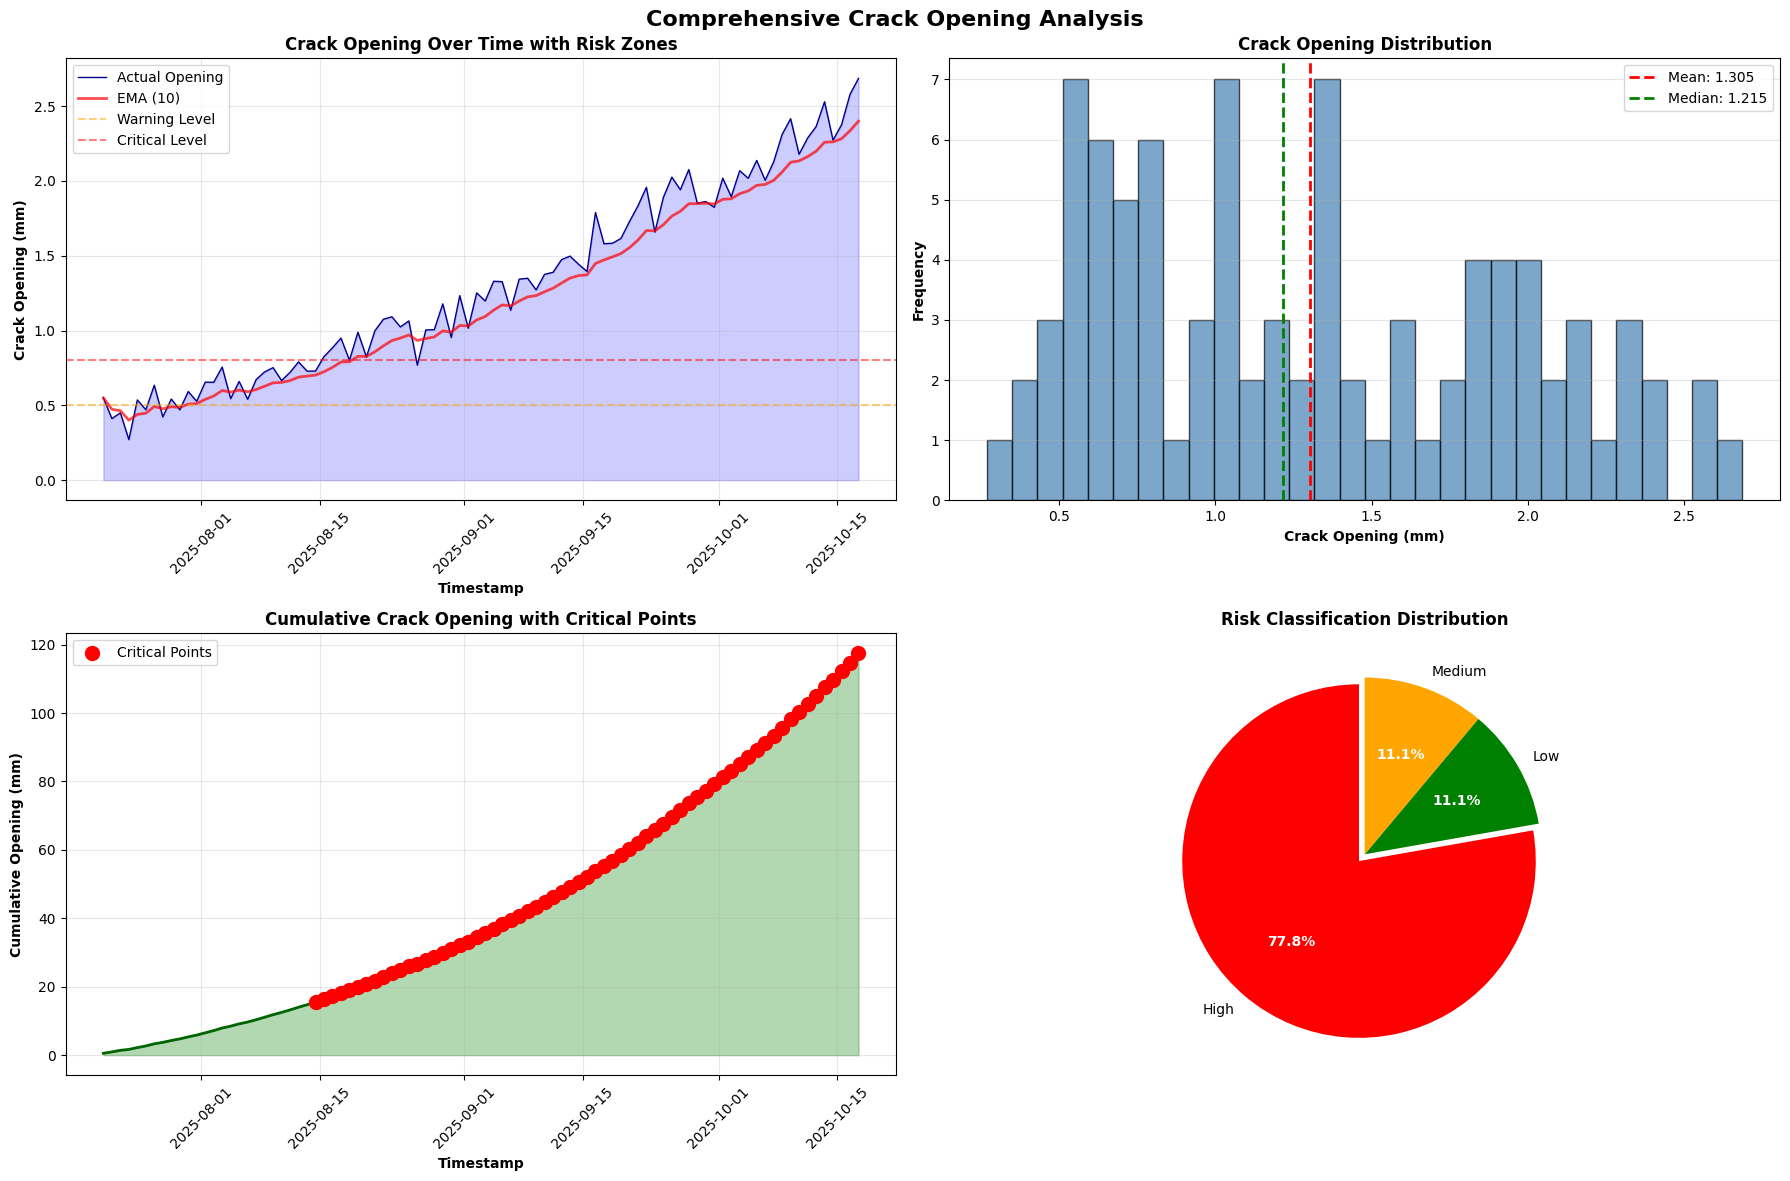

CRACK OPENING STATISTICAL SUMMARY
Mean Opening:           1.3046 mm
Median Opening:         1.2153 mm
Std Deviation:          0.6364 mm
Min Opening:            0.2708 mm
Max Opening:            2.6852 mm

Cumulative Opening:     117.4157 mm
Critical Events:        65


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Comprehensive Crack Opening Analysis', fontsize=16, fontweight='bold')

# 1. Time Series Plot with Risk Zones
ax1 = axes[0, 0]
ax1.plot(processed_df['timestamp'], processed_df['crack_opening'], 
         color='darkblue', linewidth=1, label='Actual Opening')
ax1.plot(processed_df['timestamp'], processed_df['crack_opening_ema'], 
         color='red', linewidth=2, alpha=0.7, label='EMA (10)')
ax1.fill_between(processed_df['timestamp'], 0, processed_df['crack_opening'], 
                  alpha=0.2, color='blue')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Warning Level')
ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Critical Level')
ax1.set_xlabel('Timestamp', fontweight='bold')
ax1.set_ylabel('Crack Opening (mm)', fontweight='bold')
ax1.set_title('Crack Opening Over Time with Risk Zones', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Crack Opening Distribution with Statistics
ax2 = axes[0, 1]
ax2.hist(processed_df['crack_opening'], bins=30, color='steelblue', 
         edgecolor='black', alpha=0.7)
ax2.axvline(processed_df['crack_opening'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f"Mean: {processed_df['crack_opening'].mean():.3f}")
ax2.axvline(processed_df['crack_opening'].median(), color='green', 
           linestyle='--', linewidth=2, label=f"Median: {processed_df['crack_opening'].median():.3f}")
ax2.set_xlabel('Crack Opening (mm)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Crack Opening Distribution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Cumulative Crack Opening with Critical Points
ax3 = axes[1, 0]
ax3.plot(processed_df['timestamp'], processed_df['cumulative_crack_opening'],
         color='darkgreen', linewidth=2)
critical_points = processed_df[processed_df['cumulative_crack_opening'] > 15]
if len(critical_points) > 0:
    ax3.scatter(critical_points['timestamp'], critical_points['cumulative_crack_opening'],
               color='red', s=100, zorder=5, label='Critical Points')
ax3.fill_between(processed_df['timestamp'], 0, processed_df['cumulative_crack_opening'],
                 alpha=0.3, color='green')
ax3.set_xlabel('Timestamp', fontweight='bold')
ax3.set_ylabel('Cumulative Opening (mm)', fontweight='bold')
ax3.set_title('Cumulative Crack Opening with Critical Points', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Risk Class Distribution
ax4 = axes[1, 1]
risk_counts = processed_df['risk_class'].value_counts()
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
wedges, texts, autotexts = ax4.pie(risk_counts.values, labels=risk_counts.index,
                                     autopct='%1.1f%%', startangle=90,
                                     colors=[colors[x] for x in risk_counts.index],
                                     explode=[0.05 if x == 'High' else 0 for x in risk_counts.index])
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)
ax4.set_title('Risk Classification Distribution', fontweight='bold')

plt.tight_layout()

# Save figure to images folder with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'crack_opening_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Statistical Summary
print("=" * 60)
print("CRACK OPENING STATISTICAL SUMMARY")
print("=" * 60)
print(f"Mean Opening:           {processed_df['crack_opening'].mean():.4f} mm")
print(f"Median Opening:         {processed_df['crack_opening'].median():.4f} mm")
print(f"Std Deviation:          {processed_df['crack_opening'].std():.4f} mm")
print(f"Min Opening:            {processed_df['crack_opening'].min():.4f} mm")
print(f"Max Opening:            {processed_df['crack_opening'].max():.4f} mm")
print(f"\nCumulative Opening:     {processed_df['cumulative_crack_opening'].iloc[-1]:.4f} mm")
print(f"Critical Events:        {(processed_df['cumulative_crack_opening'] > 15).sum()}")
print("=" * 60)


## 5. Crack Rate and Acceleration Analysis

Analysis of crack propagation velocity and acceleration patterns to identify rapid changes.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\crack_rate_analysis.png


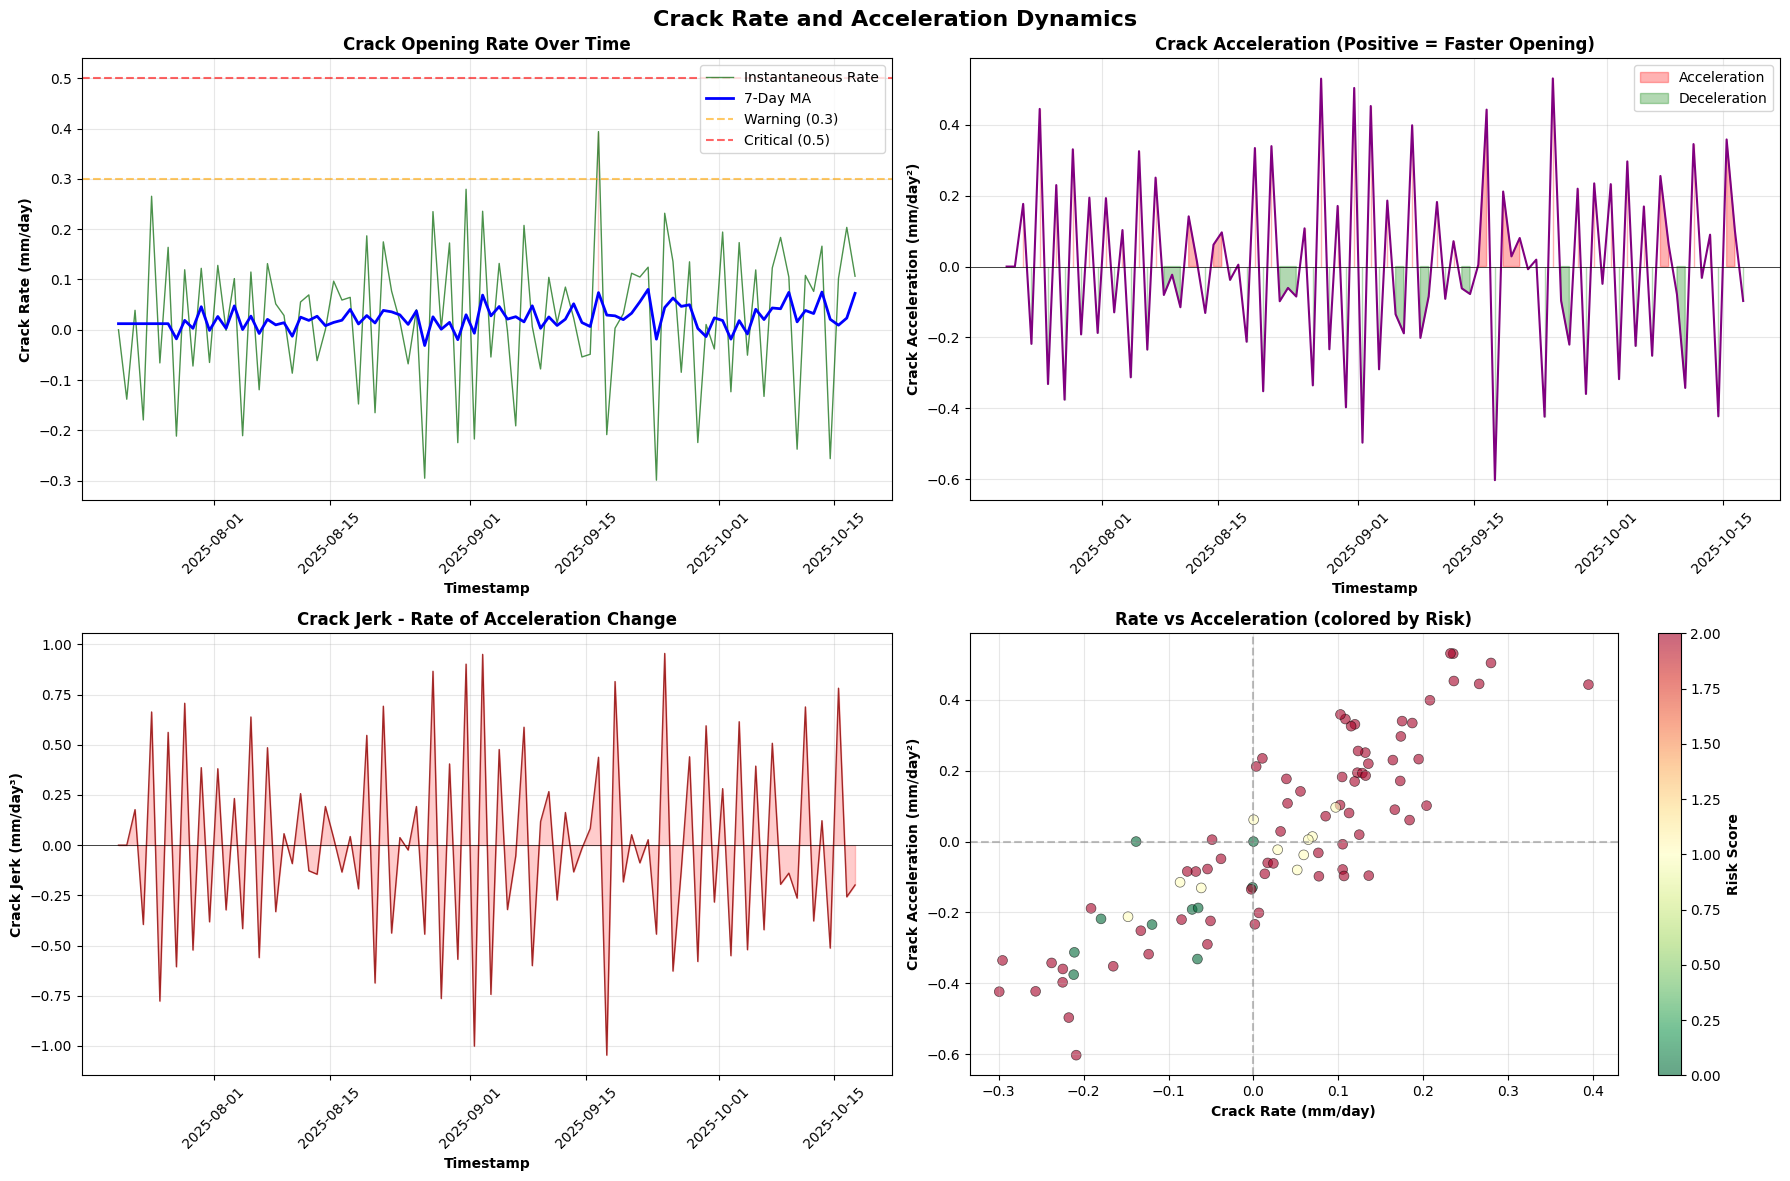

CRACK DYNAMICS STATISTICAL SUMMARY

CRACK RATE:
  Mean Rate:            0.0237 mm/day
  Max Rate:             0.3942 mm/day
  Min Rate:             -0.2992 mm/day
  Rate STD:             0.1457
  Events > 0.3 mm/day:  1
  Events > 0.5 mm/day:  0

CRACK ACCELERATION:
  Mean Accel:           0.0027 mm/day²
  Max Accel:            0.5310 mm/day²
  Positive Events:      43
  Negative Events:      45

STABILITY INDEX:
  Mean Stability Index: 0.4528
  High Instability (>1): 5


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Crack Rate and Acceleration Dynamics', fontsize=16, fontweight='bold')

# 1. Crack Rate Time Series
ax1 = axes[0, 0]
ax1.plot(processed_df['timestamp'], processed_df['crack_rate'], 
         color='darkgreen', linewidth=1, alpha=0.7, label='Instantaneous Rate')
ax1.plot(processed_df['timestamp'], processed_df['crack_velocity_ma7'], 
         color='blue', linewidth=2, label='7-Day MA')
ax1.axhline(y=0.3, color='orange', linestyle='--', alpha=0.6, label='Warning (0.3)')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, label='Critical (0.5)')
ax1.fill_between(processed_df['timestamp'], 0, processed_df['crack_rate'], 
                  where=processed_df['crack_rate'] > 0.3, alpha=0.2, color='red')
ax1.set_xlabel('Timestamp', fontweight='bold')
ax1.set_ylabel('Crack Rate (mm/day)', fontweight='bold')
ax1.set_title('Crack Opening Rate Over Time', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Acceleration Analysis
ax2 = axes[0, 1]
ax2.plot(processed_df['timestamp'], processed_df['crack_acceleration'], 
         color='purple', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.fill_between(processed_df['timestamp'], 0, processed_df['crack_acceleration'], 
                  where=processed_df['crack_acceleration'] > 0, alpha=0.3, color='red', 
                  label='Acceleration')
ax2.fill_between(processed_df['timestamp'], 0, processed_df['crack_acceleration'], 
                  where=processed_df['crack_acceleration'] < 0, alpha=0.3, color='green', 
                  label='Deceleration')
ax2.set_xlabel('Timestamp', fontweight='bold')
ax2.set_ylabel('Crack Acceleration (mm/day²)', fontweight='bold')
ax2.set_title('Crack Acceleration (Positive = Faster Opening)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Jerk Analysis (Rate of Acceleration Change)
ax3 = axes[1, 0]
ax3.plot(processed_df['timestamp'], processed_df['crack_jerk'], 
         color='darkred', linewidth=1, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.fill_between(processed_df['timestamp'], 0, processed_df['crack_jerk'], 
                  alpha=0.2, color='red')
ax3.set_xlabel('Timestamp', fontweight='bold')
ax3.set_ylabel('Crack Jerk (mm/day³)', fontweight='bold')
ax3.set_title('Crack Jerk - Rate of Acceleration Change', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Combined View: Rate vs Acceleration
ax4 = axes[1, 1]
scatter = ax4.scatter(processed_df['crack_rate'], 
                      processed_df['crack_acceleration'],
                      c=processed_df['risk_score'], 
                      cmap='RdYlGn_r', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Crack Rate (mm/day)', fontweight='bold')
ax4.set_ylabel('Crack Acceleration (mm/day²)', fontweight='bold')
ax4.set_title('Rate vs Acceleration (colored by Risk)', fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Risk Score', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'crack_rate_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Statistical Analysis
print("=" * 60)
print("CRACK DYNAMICS STATISTICAL SUMMARY")
print("=" * 60)
print("\nCRACK RATE:")
print(f"  Mean Rate:            {processed_df['crack_rate'].mean():.4f} mm/day")
print(f"  Max Rate:             {processed_df['crack_rate'].max():.4f} mm/day")
print(f"  Min Rate:             {processed_df['crack_rate'].min():.4f} mm/day")
print(f"  Rate STD:             {processed_df['crack_rate'].std():.4f}")
print(f"  Events > 0.3 mm/day:  {(processed_df['crack_rate'] > 0.3).sum()}")
print(f"  Events > 0.5 mm/day:  {(processed_df['crack_rate'] > 0.5).sum()}")

print("\nCRACK ACCELERATION:")
print(f"  Mean Accel:           {processed_df['crack_acceleration'].mean():.4f} mm/day²")
print(f"  Max Accel:            {processed_df['crack_acceleration'].max():.4f} mm/day²")
print(f"  Positive Events:      {(processed_df['crack_acceleration'] > 0).sum()}")
print(f"  Negative Events:      {(processed_df['crack_acceleration'] < 0).sum()}")

print("\nSTABILITY INDEX:")
print(f"  Mean Stability Index: {processed_df['stability_index'].mean():.4f}")
print(f"  High Instability (>1): {(processed_df['stability_index'] > 1).sum()}")
print("=" * 60)

## 6. Spatial 3D Analysis

Spatial distribution analysis of crack measurements in 3D coordinate space.

✓ 3D Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\3-D\spatial_3d_analysis.png


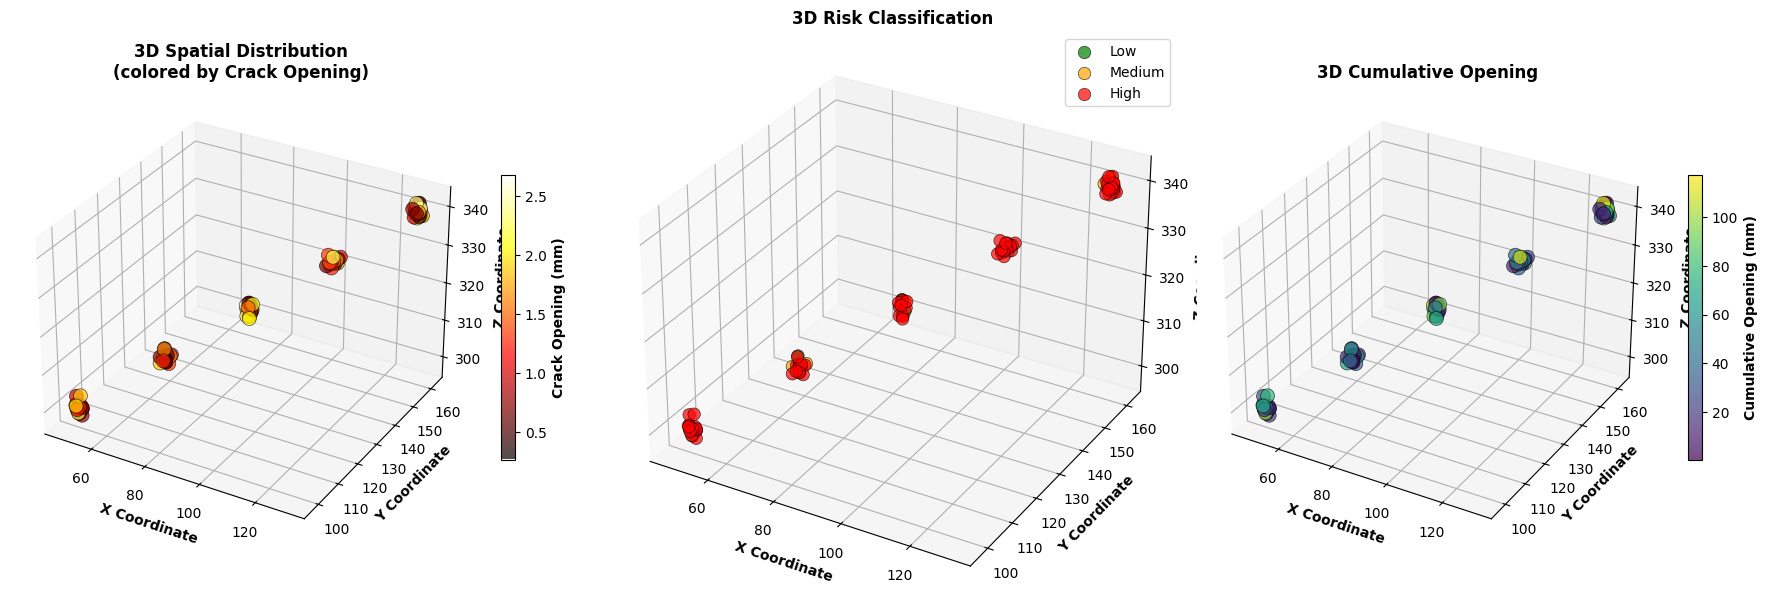

✓ 3D Spatial analysis completed


In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 6))

# 1. 3D Spatial Distribution with Crack Opening
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(processed_df['coord_x'], processed_df['coord_y'], 
                       processed_df['coord_z'], c=processed_df['crack_opening'],
                       cmap='hot', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('X Coordinate', fontweight='bold')
ax1.set_ylabel('Y Coordinate', fontweight='bold')
ax1.set_zlabel('Z Coordinate', fontweight='bold')
ax1.set_title('3D Spatial Distribution\n(colored by Crack Opening)', fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.5)
cbar1.set_label('Crack Opening (mm)', fontweight='bold')

# 2. 3D with Risk Classification
ax2 = fig.add_subplot(132, projection='3d')
colors_map = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for risk in ['Low', 'Medium', 'High']:
    mask = processed_df['risk_class'] == risk
    ax2.scatter(processed_df[mask]['coord_x'], processed_df[mask]['coord_y'],
                processed_df[mask]['coord_z'], c=colors_map[risk], 
                label=risk, s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('X Coordinate', fontweight='bold')
ax2.set_ylabel('Y Coordinate', fontweight='bold')
ax2.set_zlabel('Z Coordinate', fontweight='bold')
ax2.set_title('3D Risk Classification', fontweight='bold')
ax2.legend()

# 3. 3D with Cumulative Opening
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(processed_df['coord_x'], processed_df['coord_y'], 
                       processed_df['coord_z'], c=processed_df['cumulative_crack_opening'],
                       cmap='viridis', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('X Coordinate', fontweight='bold')
ax3.set_ylabel('Y Coordinate', fontweight='bold')
ax3.set_zlabel('Z Coordinate', fontweight='bold')
ax3.set_title('3D Cumulative Opening', fontweight='bold')
cbar3 = plt.colorbar(scatter3, ax=ax3, shrink=0.5)
cbar3.set_label('Cumulative Opening (mm)', fontweight='bold')

plt.tight_layout()

# Save 3D visualization to 3-D folder with non-overwrite
image_path = get_next_filename(THREED_DIR, 'spatial_3d_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ 3D Image saved: {image_path}")

plt.show()

print("✓ 3D Spatial analysis completed")

## 7. Correlation Analysis

Advanced correlation analysis between all crack monitoring parameters.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\correlation_analysis.png


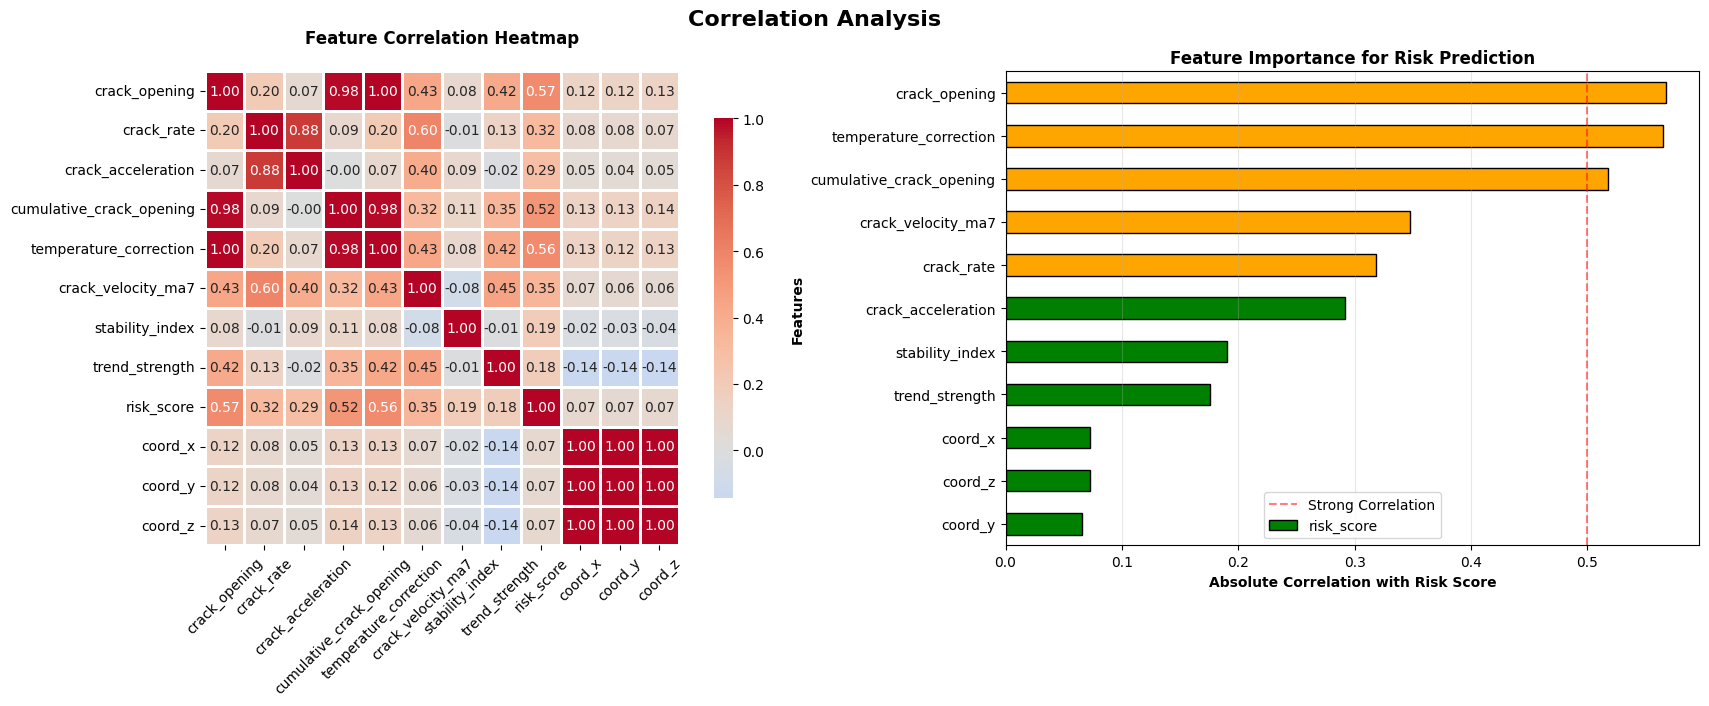

STRONG CORRELATIONS (|r| > 0.7)
crack_opening                  <-> cumulative_crack_opening       :  0.984
crack_opening                  <-> temperature_correction         :  1.000
crack_rate                     <-> crack_acceleration             :  0.878
cumulative_crack_opening       <-> temperature_correction         :  0.984
coord_x                        <-> coord_y                        :  0.998
coord_x                        <-> coord_z                        :  0.997
coord_y                        <-> coord_z                        :  0.996

Top 5 Risk Predictors:
  crack_opening                  : 0.568
  temperature_correction         : 0.565
  cumulative_crack_opening       : 0.518
  crack_velocity_ma7             : 0.348
  crack_rate                     : 0.318


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')

# Select key features for correlation
correlation_features = [
    'crack_opening', 'crack_rate', 'crack_acceleration',
    'cumulative_crack_opening', 'temperature_correction',
    'crack_velocity_ma7', 'stability_index', 'trend_strength',
    'risk_score', 'coord_x', 'coord_y', 'coord_z'
]

corr_df = processed_df[correlation_features].corr()

# 1. Full Correlation Heatmap
ax1 = axes[0]
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Feature Correlation Heatmap', fontweight='bold', pad=20)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# 2. Top Correlations with Risk Score
ax2 = axes[1]
risk_corr = corr_df['risk_score'].drop('risk_score').abs().sort_values(ascending=True)
colors = ['green' if x < 0.3 else 'orange' if x < 0.6 else 'red' for x in risk_corr]
risk_corr.plot(kind='barh', ax=ax2, color=colors, edgecolor='black', linewidth=1)
ax2.set_xlabel('Absolute Correlation with Risk Score', fontweight='bold')
ax2.set_ylabel('Features', fontweight='bold')
ax2.set_title('Feature Importance for Risk Prediction', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Strong Correlation')
ax2.legend()

plt.tight_layout()

# Save correlation analysis with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'correlation_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Print Strong Correlations
print("=" * 60)
print("STRONG CORRELATIONS (|r| > 0.7)")
print("=" * 60)
for i in range(len(corr_df.columns)):
    for j in range(i+1, len(corr_df.columns)):
        if abs(corr_df.iloc[i, j]) > 0.7:
            print(f"{corr_df.columns[i]:30s} <-> {corr_df.columns[j]:30s} : {corr_df.iloc[i,j]:6.3f}")
print("=" * 60)

print("\nTop 5 Risk Predictors:")
top_risk_corr = corr_df['risk_score'].drop('risk_score').abs().sort_values(ascending=False).head(5)
for feature, corr_val in top_risk_corr.items():
    print(f"  {feature:30s} : {corr_val:.3f}")

## 8. Real-Time Alert System

Multi-level alert system for landslide early warning based on crack behavior thresholds.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\alert_system_dashboard.png


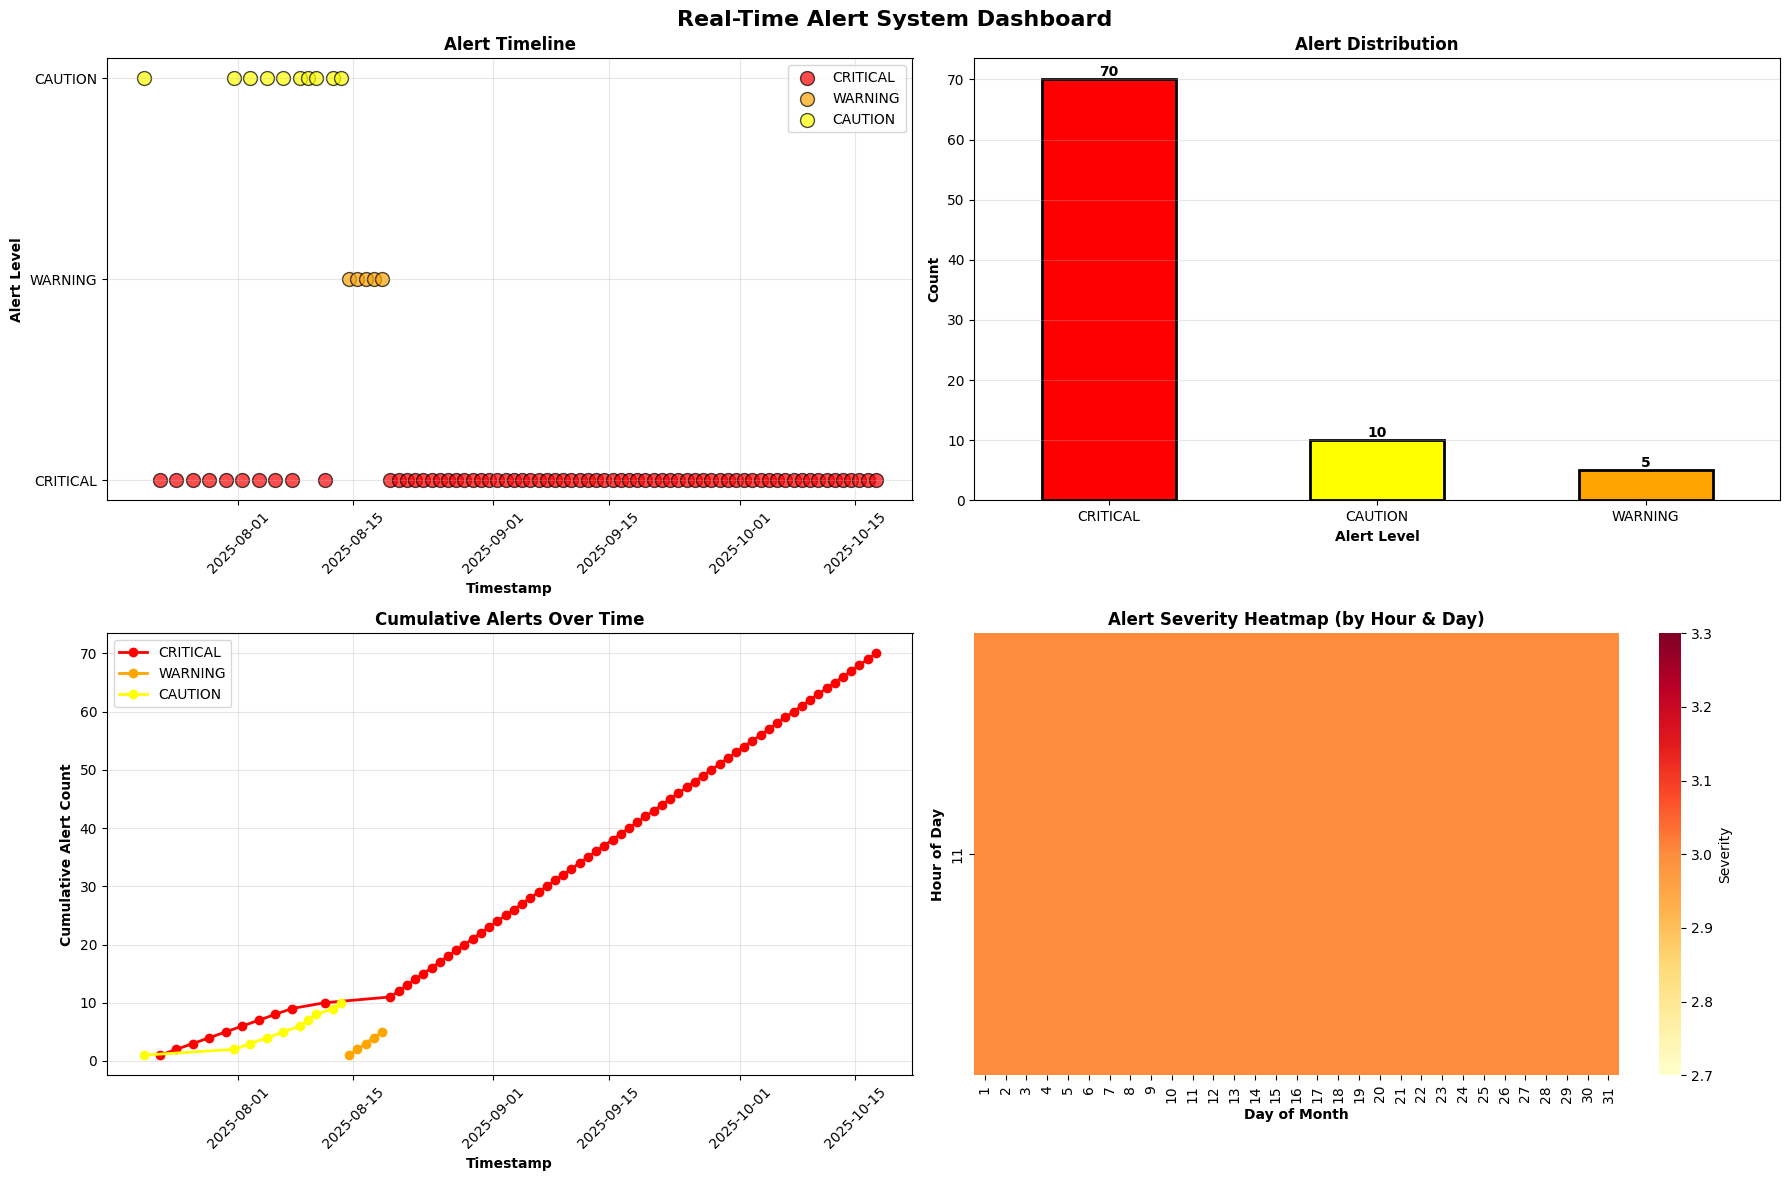

ALERT SYSTEM SUMMARY
Total Alerts Generated: 85

Alert Breakdown:
  CRITICAL  :   70 (82.4%)
  CAUTION   :   10 (11.8%)

Most Recent CRITICAL Alerts:

  [2025-10-15 11:44:57.974135]
    - Cumulative opening exceeds 20mm (112.15mm)
    - High acceleration detected (0.3587mm/day²)

  [2025-10-16 11:44:57.974135]
    - Cumulative opening exceeds 20mm (114.73mm)
    - High acceleration detected (0.1013mm/day²)

  [2025-10-17 11:44:57.974135]
    - Cumulative opening exceeds 20mm (117.42mm)


In [26]:
def generate_alerts(df):
    """
    Generate multi-level alerts based on crack monitoring thresholds.
    """
    alerts = []
    
    for idx, row in df.iterrows():
        alert_level = 'NORMAL'
        reasons = []
        
        # Critical Alerts (Level 3)
        if row['cumulative_crack_opening'] > 20:
            alert_level = 'CRITICAL'
            reasons.append(f"Cumulative opening exceeds 20mm ({row['cumulative_crack_opening']:.2f}mm)")
        
        if row['crack_rate'] > 0.6:
            alert_level = 'CRITICAL'
            reasons.append(f"Crack rate exceeds 0.6mm/day ({row['crack_rate']:.3f}mm/day)")
        
        if row['crack_acceleration'] > 0.1:
            alert_level = 'CRITICAL'
            reasons.append(f"High acceleration detected ({row['crack_acceleration']:.4f}mm/day²)")
        
        # Warning Alerts (Level 2)
        if alert_level != 'CRITICAL':
            if row['cumulative_crack_opening'] > 15:
                alert_level = 'WARNING'
                reasons.append(f"Cumulative opening > 15mm ({row['cumulative_crack_opening']:.2f}mm)")
            
            if row['crack_rate'] > 0.4:
                alert_level = 'WARNING'
                reasons.append(f"Elevated crack rate ({row['crack_rate']:.3f}mm/day)")
            
            if row['stability_index'] > 1.2:
                alert_level = 'WARNING'
                reasons.append(f"High instability index ({row['stability_index']:.3f})")
        
        # Caution Alerts (Level 1)
        if alert_level == 'NORMAL':
            if row['crack_opening'] > 0.5:
                alert_level = 'CAUTION'
                reasons.append(f"Crack opening > 0.5mm ({row['crack_opening']:.3f}mm)")
            
            if row['trend_strength'] > 0.05:
                alert_level = 'CAUTION'
                reasons.append(f"Positive trend detected ({row['trend_strength']:.4f})")
        
        if reasons:
            alerts.append({
                'timestamp': row['timestamp'],
                'level': alert_level,
                'reasons': reasons,
                'crack_opening': row['crack_opening'],
                'cumulative_opening': row['cumulative_crack_opening'],
                'crack_rate': row['crack_rate']
            })
    
    return pd.DataFrame(alerts)

# Generate alerts
alerts_df = generate_alerts(processed_df)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Real-Time Alert System Dashboard', fontsize=16, fontweight='bold')

# 1. Alert Timeline
ax1 = axes[0, 0]
if len(alerts_df) > 0:
    alert_counts = alerts_df['level'].value_counts()
    level_colors = {'CRITICAL': 'red', 'WARNING': 'orange', 'CAUTION': 'yellow', 'NORMAL': 'green'}
    
    for level in ['CRITICAL', 'WARNING', 'CAUTION']:
        if level in alerts_df['level'].values:
            level_alerts = alerts_df[alerts_df['level'] == level]
            ax1.scatter(level_alerts['timestamp'], 
                       [level] * len(level_alerts),
                       c=level_colors[level], s=100, alpha=0.7, 
                       edgecolors='black', linewidth=1, label=level)
    
    ax1.set_xlabel('Timestamp', fontweight='bold')
    ax1.set_ylabel('Alert Level', fontweight='bold')
    ax1.set_title('Alert Timeline', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

# 2. Alert Distribution
ax2 = axes[0, 1]
if len(alerts_df) > 0:
    alert_counts = alerts_df['level'].value_counts()
    colors = [level_colors[level] for level in alert_counts.index]
    alert_counts.plot(kind='bar', ax=ax2, color=colors, edgecolor='black', linewidth=2)
    ax2.set_xlabel('Alert Level', fontweight='bold')
    ax2.set_ylabel('Count', fontweight='bold')
    ax2.set_title('Alert Distribution', fontweight='bold')
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for i, v in enumerate(alert_counts):
        ax2.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# 3. Cumulative Alerts Over Time
ax3 = axes[1, 0]
if len(alerts_df) > 0:
    for level, color in [('CRITICAL', 'red'), ('WARNING', 'orange'), ('CAUTION', 'yellow')]:
        level_data = alerts_df[alerts_df['level'] == level].copy()
        if len(level_data) > 0:
            level_data = level_data.sort_values('timestamp')
            level_data['cumulative_count'] = range(1, len(level_data) + 1)
            ax3.plot(level_data['timestamp'], level_data['cumulative_count'], 
                    color=color, linewidth=2, marker='o', label=level)
    
    ax3.set_xlabel('Timestamp', fontweight='bold')
    ax3.set_ylabel('Cumulative Alert Count', fontweight='bold')
    ax3.set_title('Cumulative Alerts Over Time', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

# 4. Alert Severity Heatmap
ax4 = axes[1, 1]
severity_score = {'CRITICAL': 3, 'WARNING': 2, 'CAUTION': 1, 'NORMAL': 0}
processed_df['alert_severity'] = 0
if len(alerts_df) > 0:
    for idx, alert in alerts_df.iterrows():
        mask = processed_df['timestamp'] == alert['timestamp']
        processed_df.loc[mask, 'alert_severity'] = severity_score[alert['level']]

# Create hourly heatmap
processed_df['hour'] = processed_df['timestamp'].dt.hour
processed_df['day'] = processed_df['timestamp'].dt.day
pivot_table = processed_df.pivot_table(values='alert_severity', 
                                        index='hour', columns='day', 
                                        aggfunc='max', fill_value=0)
sns.heatmap(pivot_table, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Severity'})
ax4.set_xlabel('Day of Month', fontweight='bold')
ax4.set_ylabel('Hour of Day', fontweight='bold')
ax4.set_title('Alert Severity Heatmap (by Hour & Day)', fontweight='bold')

plt.tight_layout()

# Save alert system dashboard with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'alert_system_dashboard', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Print Alert Summary
print("=" * 80)
print("ALERT SYSTEM SUMMARY")
print("=" * 80)
if len(alerts_df) > 0:
    print(f"Total Alerts Generated: {len(alerts_df)}")
    print(f"\nAlert Breakdown:")
    for level in ['CRITICAL', 'WARNING', 'CAUTION']:
        count = len(alerts_df[alerts_df['level'] == level])
        print(f"  {level:10s}: {count:4d} ({count/len(alerts_df)*100:.1f}%)")
    
    print(f"\nMost Recent CRITICAL Alerts:")
    critical_alerts = alerts_df[alerts_df['level'] == 'CRITICAL'].tail(3)
    for idx, alert in critical_alerts.iterrows():
        print(f"\n  [{alert['timestamp']}]")
        for reason in alert['reasons']:
            print(f"    - {reason}")
else:
    print("No alerts generated - all parameters within normal range")
print("=" * 80)

## 9. Interactive Dashboard (Plotly)

Interactive web-based visualizations for dynamic exploration of crack monitoring data.

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Create interactive dashboard with improved layout
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Crack Opening Time Series', '3D Spatial Risk Distribution',
                    'Rate vs Acceleration (Risk Colored)', 'Cumulative Opening Trend'),
    specs=[[{'type': 'scatter'}, {'type': 'scatter3d'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]],
    vertical_spacing=0.15,
    horizontal_spacing=0.12
)

# 1. Interactive Time Series with dual lines
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['crack_opening'],
               mode='lines', name='Crack Opening',
               line=dict(color='#1f77b4', width=2),
               fill='tozeroy', fillcolor='rgba(31, 119, 180, 0.2)',
               hovertemplate='<b>Time</b>: %{x}<br><b>Opening</b>: %{y:.3f} mm<extra></extra>'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=processed_df['timestamp'], y=processed_df['crack_opening_ema'],
               mode='lines', name='EMA (10)',
               line=dict(color='#ff7f0e', width=2.5, dash='dash'),
               hovertemplate='<b>Time</b>: %{x}<br><b>EMA</b>: %{y:.3f} mm<extra></extra>'),
    row=1, col=1
)

# Add warning lines
fig.add_trace(
    go.Scatter(x=[processed_df['timestamp'].min(), processed_df['timestamp'].max()],
               y=[0.5, 0.5],
               mode='lines', name='Warning Level',
               line=dict(color='orange', width=2, dash='dot'),
               hoverinfo='skip'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=[processed_df['timestamp'].min(), processed_df['timestamp'].max()],
               y=[0.8, 0.8],
               mode='lines', name='Critical Level',
               line=dict(color='red', width=2, dash='dot'),
               hoverinfo='skip'),
    row=1, col=1
)

# 2. 3D Scatter with Risk Classification
color_map = {'Low': '#2ca02c', 'Medium': '#ff7f0e', 'High': '#d62728'}
for risk in ['Low', 'Medium', 'High']:
    mask = processed_df['risk_class'] == risk
    if mask.sum() > 0:  # Only add if there are points
        fig.add_trace(
            go.Scatter3d(
                x=processed_df[mask]['coord_x'],
                y=processed_df[mask]['coord_y'],
                z=processed_df[mask]['coord_z'],
                mode='markers',
                name=f'{risk} Risk',
                marker=dict(
                    size=8,
                    color=color_map[risk],
                    opacity=0.8,
                    line=dict(color='white', width=0.5)
                ),
                hovertemplate=f'<b>{risk} Risk</b><br>X: %{{x:.1f}}<br>Y: %{{y:.1f}}<br>Z: %{{z:.1f}}<extra></extra>'),
            row=1, col=2
        )

# 3. Rate vs Acceleration Scatter
fig.add_trace(
    go.Scatter(
        x=processed_df['crack_rate'],
        y=processed_df['crack_acceleration'],
        mode='markers',
        name='Measurements',
        marker=dict(
            size=10,
            color=processed_df['risk_score'],
            colorscale='RdYlGn_r',
            showscale=True,
            colorbar=dict(
                title="Risk<br>Score",
                x=0.47,
                len=0.35,
                thickness=15
            ),
            line=dict(color='white', width=0.5)
        ),
        hovertemplate='<b>Rate</b>: %{x:.3f} mm/day<br><b>Accel</b>: %{y:.4f} mm/day²<br><extra></extra>'),
    row=2, col=1
)

# Add reference lines at origin
fig.add_trace(
    go.Scatter(x=[-0.35, 0.45], y=[0, 0],
               mode='lines', name='Zero Accel',
               line=dict(color='gray', width=1, dash='dash'),
               showlegend=False, hoverinfo='skip'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=[0, 0], y=[-0.7, 0.6],
               mode='lines', name='Zero Rate',
               line=dict(color='gray', width=1, dash='dash'),
               showlegend=False, hoverinfo='skip'),
    row=2, col=1
)

# 4. Cumulative Opening with area fill
fig.add_trace(
    go.Scatter(
        x=processed_df['timestamp'],
        y=processed_df['cumulative_crack_opening'],
        mode='lines',
        name='Cumulative',
        fill='tozeroy',
        fillcolor='rgba(214, 39, 40, 0.3)',
        line=dict(color='#d62728', width=3),
        hovertemplate='<b>Time</b>: %{x}<br><b>Cumulative</b>: %{y:.2f} mm<extra></extra>'),
    row=2, col=2
)

# Add critical threshold line
fig.add_trace(
    go.Scatter(x=[processed_df['timestamp'].min(), processed_df['timestamp'].max()],
               y=[15, 15],
               mode='lines', name='Critical Threshold',
               line=dict(color='red', width=2, dash='dot'),
               hoverinfo='skip'),
    row=2, col=2
)

# Update axes titles
fig.update_xaxes(title_text="<b>Timestamp</b>", row=1, col=1, showgrid=True)
fig.update_yaxes(title_text="<b>Crack Opening (mm)</b>", row=1, col=1, showgrid=True)

fig.update_xaxes(title_text="<b>Rate (mm/day)</b>", row=2, col=1, showgrid=True)
fig.update_yaxes(title_text="<b>Acceleration (mm/day²)</b>", row=2, col=1, showgrid=True)

fig.update_xaxes(title_text="<b>Timestamp</b>", row=2, col=2, showgrid=True)
fig.update_yaxes(title_text="<b>Cumulative Opening (mm)</b>", row=2, col=2, showgrid=True)

# Update 3D scene
fig.update_scenes(
    xaxis=dict(title="<b>X Coordinate</b>", backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
    yaxis=dict(title="<b>Y Coordinate</b>", backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
    zaxis=dict(title="<b>Z Coordinate</b>", backgroundcolor="rgb(230, 230,230)", gridcolor="white"),
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.3)),
    row=1, col=2
)

# Update overall layout
fig.update_layout(
    title=dict(
        text="<b>Interactive Extensometer Monitoring Dashboard</b>",
        font=dict(size=22, color='#2c3e50'),
        x=0.5,
        xanchor='center'
    ),
    height=900,
    showlegend=True,
    hovermode='closest',
    plot_bgcolor='rgba(240, 240, 240, 0.5)',
    paper_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=11),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.98,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255, 255, 255, 0.9)",
        bordercolor="gray",
        borderwidth=1
    )
)

# Save interactive dashboard to 3-D folder as HTML with non-overwrite
html_path = get_next_filename(THREED_DIR, 'interactive_dashboard', '.html')
fig.write_html(html_path)
print(f"✓ Interactive 3D dashboard saved: {html_path}")

fig.show()

print("=" * 80)
print("✓ Interactive dashboard created successfully")
print("=" * 80)
print("Features:")
print("  • Hover over data points for detailed information")
print("  • Use toolbar to zoom, pan, and rotate 3D view")
print("  • Click legend items to toggle traces on/off")
print("  • Double-click to reset view")
print("=" * 80)

✓ Interactive 3D dashboard saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\3-D\interactive_dashboard.html


✓ Interactive dashboard created successfully
Features:
  • Hover over data points for detailed information
  • Use toolbar to zoom, pan, and rotate 3D view
  • Click legend items to toggle traces on/off
  • Double-click to reset view


## 10. Advanced Statistical Analysis

In-depth statistical analysis including normality tests, decomposition, and dimensionality reduction.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\statistical_analysis.png


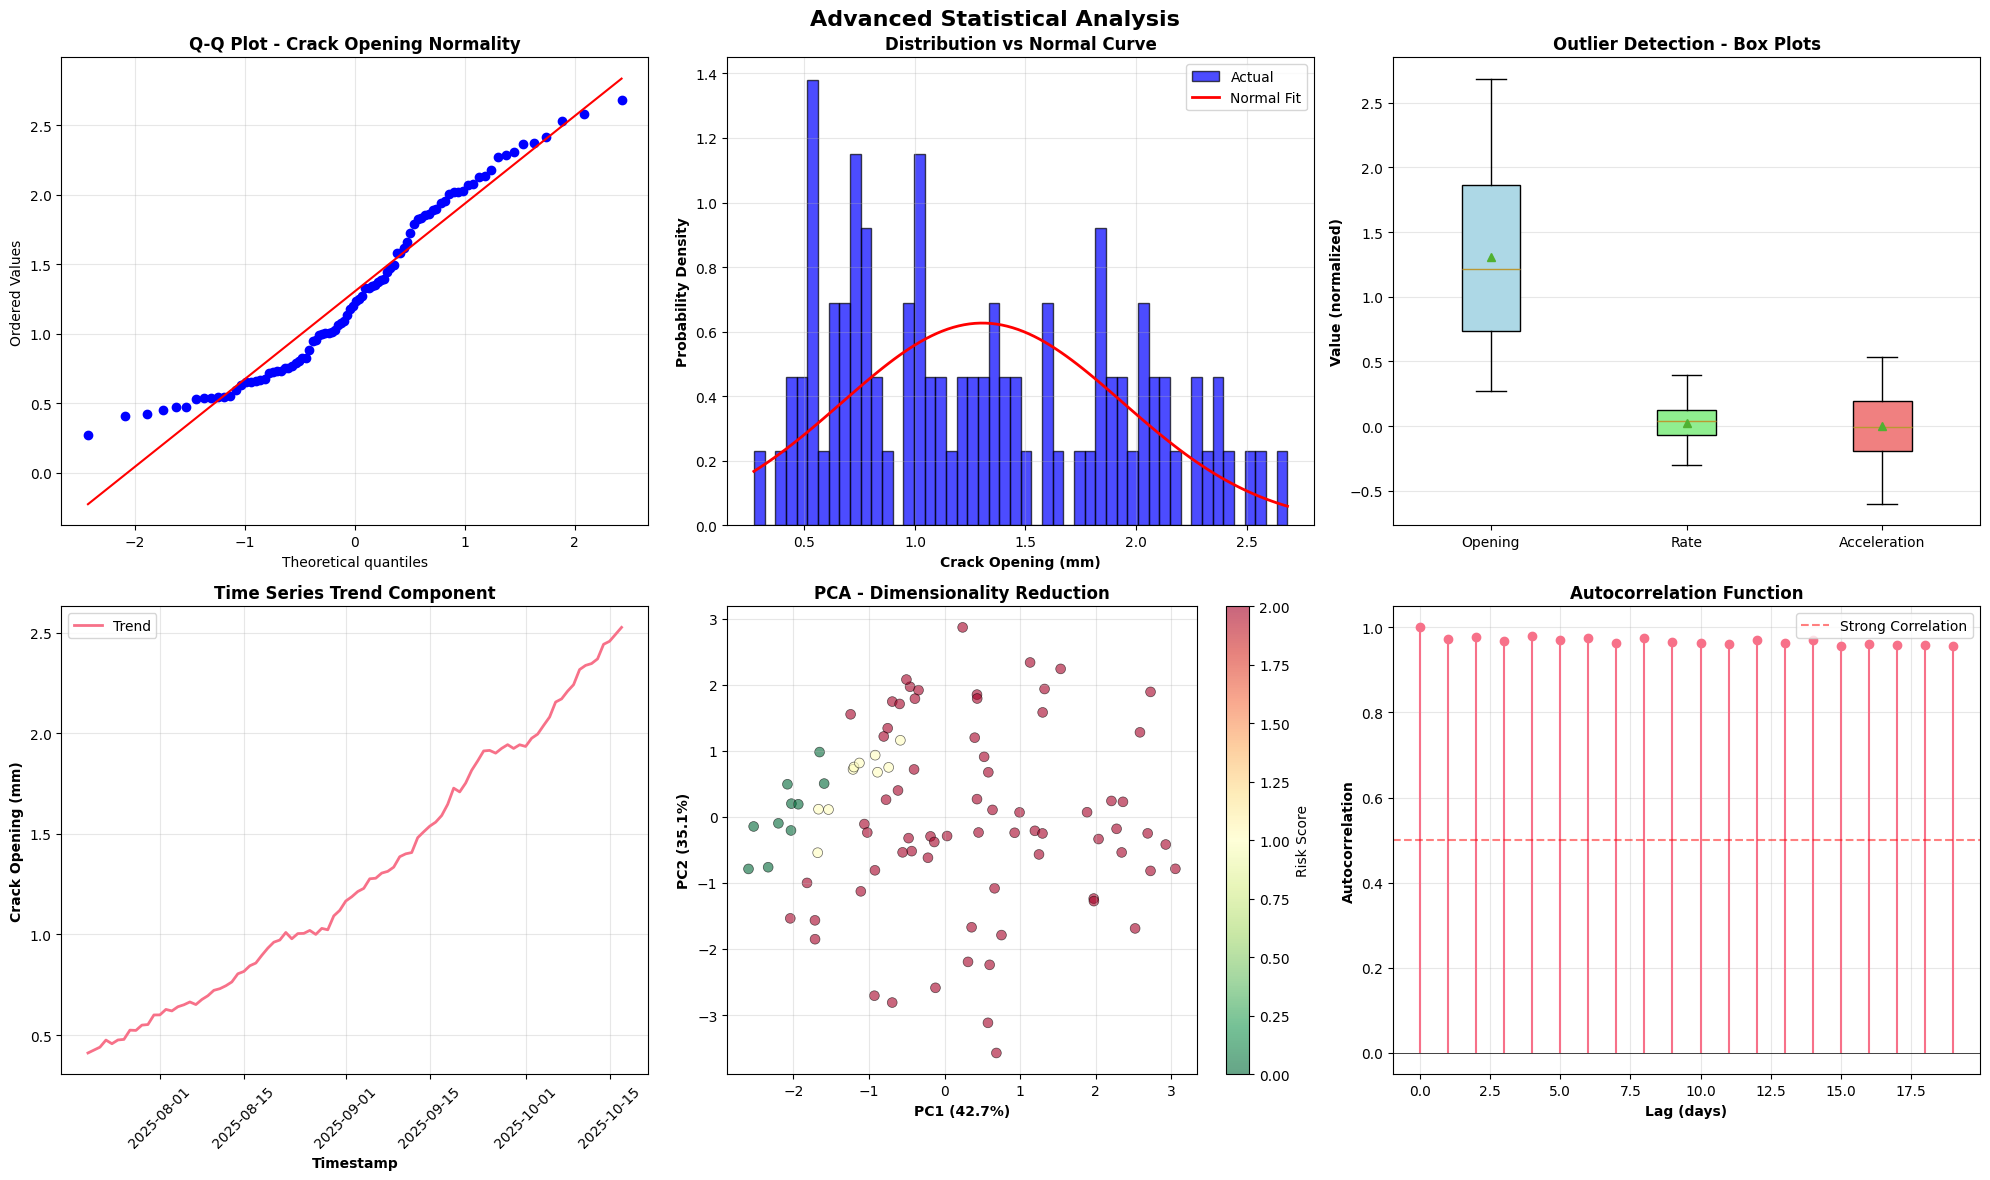

STATISTICAL TEST RESULTS

Shapiro-Wilk Normality Test:
  Statistic: 0.9453
  P-value:   0.0009
  Result:    Not Normal distribution (α=0.05)

Descriptive Statistics:
  Skewness:  0.3572
  Kurtosis:  -1.0573

PCA Analysis:
  Total Variance Explained: 77.81%
  PC1 Variance: 42.74%
  PC2 Variance: 35.07%


In [28]:
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Advanced Statistical Analysis', fontsize=16, fontweight='bold')

# 1. Q-Q Plot for Normality
ax1 = axes[0, 0]
stats.probplot(processed_df['crack_opening'], dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot - Crack Opening Normality', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Distribution Comparison
ax2 = axes[0, 1]
ax2.hist(processed_df['crack_opening'], bins=50, density=True, alpha=0.7, 
         color='blue', edgecolor='black', label='Actual')
mu, sigma = processed_df['crack_opening'].mean(), processed_df['crack_opening'].std()
x = np.linspace(processed_df['crack_opening'].min(), processed_df['crack_opening'].max(), 100)
ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Fit')
ax2.set_xlabel('Crack Opening (mm)', fontweight='bold')
ax2.set_ylabel('Probability Density', fontweight='bold')
ax2.set_title('Distribution vs Normal Curve', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Box Plot for Outlier Detection
ax3 = axes[0, 2]
box_data = [processed_df['crack_opening'], processed_df['crack_rate'], 
            processed_df['crack_acceleration']]
bp = ax3.boxplot(box_data, labels=['Opening', 'Rate', 'Acceleration'],
                 patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
ax3.set_ylabel('Value (normalized)', fontweight='bold')
ax3.set_title('Outlier Detection - Box Plots', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Time Series Decomposition
ax4 = axes[1, 0]
# Resample to daily if needed for decomposition
ts_data = processed_df.set_index('timestamp')['crack_opening'].resample('D').mean().fillna(method='ffill')
if len(ts_data) >= 14:  # Need sufficient data for decomposition
    decomposition = seasonal_decompose(ts_data, model='additive', period=7, extrapolate_trend='freq')
    ax4.plot(decomposition.trend.index, decomposition.trend.values, label='Trend', linewidth=2)
    ax4.set_xlabel('Timestamp', fontweight='bold')
    ax4.set_ylabel('Crack Opening (mm)', fontweight='bold')
    ax4.set_title('Time Series Trend Component', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)

# 5. PCA Analysis
ax5 = axes[1, 1]
pca_features = ['crack_opening', 'crack_rate', 'crack_acceleration', 
                'cumulative_crack_opening', 'stability_index']
X_pca = processed_df[pca_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
pca = PCA(n_components=2)
X_pca_transformed = pca.fit_transform(X_scaled)

scatter = ax5.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1],
                      c=processed_df['risk_score'], cmap='RdYlGn_r',
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax5.set_title('PCA - Dimensionality Reduction', fontweight='bold')
plt.colorbar(scatter, ax=ax5, label='Risk Score')
ax5.grid(True, alpha=0.3)

# 6. Correlation with Lag
ax6 = axes[1, 2]
lags = range(0, 20)
autocorr = [processed_df['crack_opening'].autocorr(lag=i) for i in lags]
ax6.stem(lags, autocorr, basefmt=' ')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Strong Correlation')
ax6.set_xlabel('Lag (days)', fontweight='bold')
ax6.set_ylabel('Autocorrelation', fontweight='bold')
ax6.set_title('Autocorrelation Function', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()

# Save statistical analysis with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'statistical_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Statistical Tests
print("=" * 60)
print("STATISTICAL TEST RESULTS")
print("=" * 60)

# Normality Tests
shapiro_stat, shapiro_p = stats.shapiro(processed_df['crack_opening'].sample(min(5000, len(processed_df))))
print(f"\nShapiro-Wilk Normality Test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  P-value:   {shapiro_p:.4f}")
print(f"  Result:    {'Normal' if shapiro_p > 0.05 else 'Not Normal'} distribution (α=0.05)")

# Descriptive Statistics
print(f"\nDescriptive Statistics:")
print(f"  Skewness:  {stats.skew(processed_df['crack_opening']):.4f}")
print(f"  Kurtosis:  {stats.kurtosis(processed_df['crack_opening']):.4f}")

# PCA Summary
print(f"\nPCA Analysis:")
print(f"  Total Variance Explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"  PC1 Variance: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2 Variance: {pca.explained_variance_ratio_[1]*100:.2f}%")

print("=" * 60)

## 11. Machine Learning Models

Predictive models for crack risk classification and rate prediction using ensemble methods.

Training Risk Classification Model...
Training Crack Rate Prediction Model...
✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\ml_analysis.png
✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\ml_analysis.png


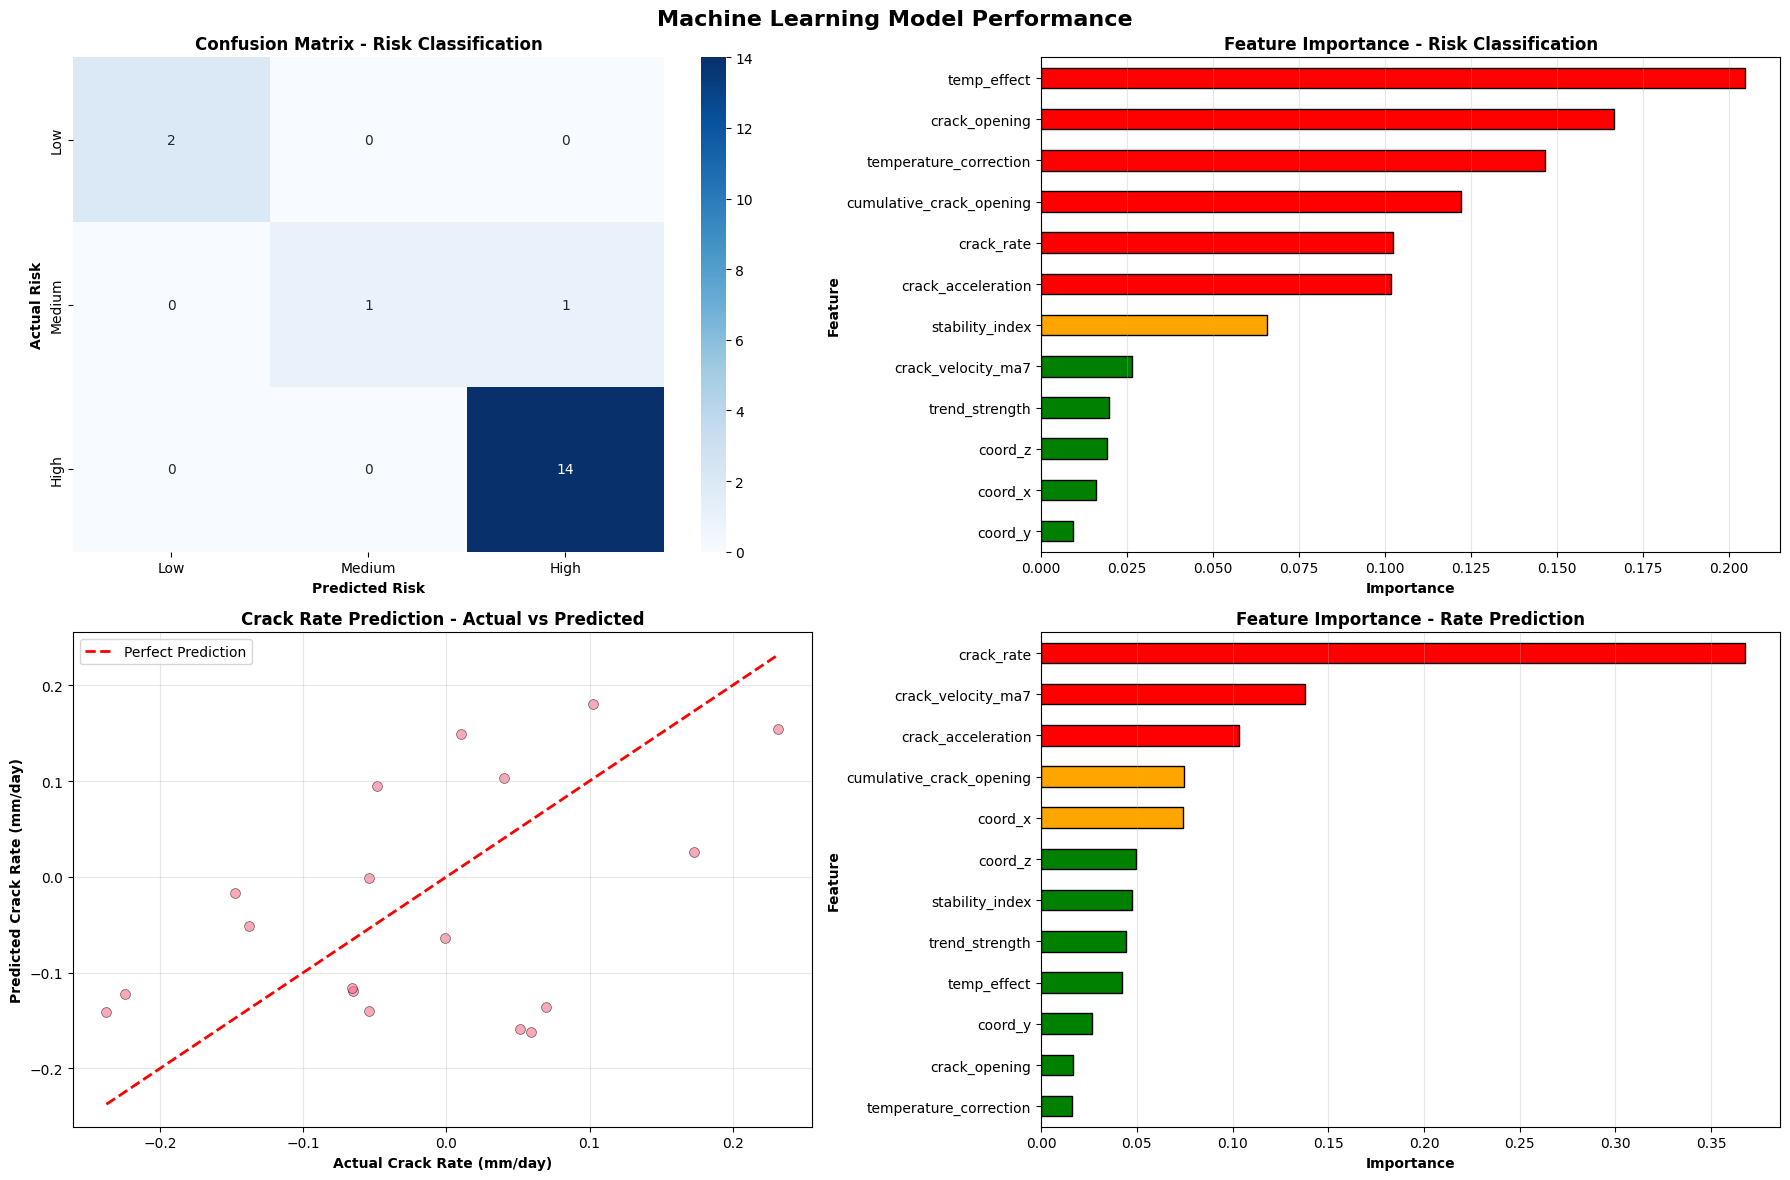

MACHINE LEARNING MODEL EVALUATION

1. RISK CLASSIFICATION MODEL (Random Forest):
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Low Risk       1.00      1.00      1.00         2
 Medium Risk       1.00      0.50      0.67         2
   High Risk       0.93      1.00      0.97        14

    accuracy                           0.94        18
   macro avg       0.98      0.83      0.88        18
weighted avg       0.95      0.94      0.94        18

Overall Accuracy: 94.44%

2. CRACK RATE PREDICTION MODEL (Gradient Boosting):
----------------------------------------------------------------------
R² Score:              -0.0376
RMSE:                  0.1239 mm/day
MAE:                   0.1114 mm/day

3. TOP PREDICTIVE FEATURES:
----------------------------------------------------------------------
Classification Model:
  crack_rate                    : 0.1024
  cumulative_crack_opening      : 0.1220
  tempera

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error
import joblib

# Prepare features for ML
ml_features = [
    'crack_opening', 'crack_rate', 'crack_acceleration',
    'cumulative_crack_opening', 'temperature_correction',
    'crack_velocity_ma7', 'stability_index', 'trend_strength',
    'temp_effect', 'coord_x', 'coord_y', 'coord_z'
]

# Clean data for ML
ml_df = processed_df[ml_features + ['risk_score']].copy()
ml_df = ml_df.fillna(ml_df.mean())
ml_df = ml_df.replace([np.inf, -np.inf], 0)

X = ml_df[ml_features]
y_classification = ml_df['risk_score']  # Risk classification target
y_regression = ml_df['crack_rate'].shift(-1).fillna(ml_df['crack_rate'].mean())  # Predict next rate

# Train-test split
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Model 1: Risk Classification (RandomForest)
print("Training Risk Classification Model...")
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_class_train)
y_pred_class = rf_classifier.predict(X_test)

# Model 2: Crack Rate Prediction (GradientBoosting)
print("Training Crack Rate Prediction Model...")
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_regressor.fit(X_train_reg, y_reg_train)
y_pred_reg = gb_regressor.predict(X_test_reg)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Machine Learning Model Performance', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
ax1 = axes[0, 0]
cm = confusion_matrix(y_class_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax1.set_xlabel('Predicted Risk', fontweight='bold')
ax1.set_ylabel('Actual Risk', fontweight='bold')
ax1.set_title('Confusion Matrix - Risk Classification', fontweight='bold')

# 2. Feature Importance (Classification)
ax2 = axes[0, 1]
feature_importance_class = pd.DataFrame({
    'feature': ml_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=True)
colors = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' 
          for x in feature_importance_class['importance']]
feature_importance_class.plot(x='feature', y='importance', kind='barh', 
                              ax=ax2, color=colors, legend=False, edgecolor='black')
ax2.set_xlabel('Importance', fontweight='bold')
ax2.set_ylabel('Feature', fontweight='bold')
ax2.set_title('Feature Importance - Risk Classification', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Regression: Actual vs Predicted
ax3 = axes[1, 0]
ax3.scatter(y_reg_test, y_pred_reg, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax3.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Crack Rate (mm/day)', fontweight='bold')
ax3.set_ylabel('Predicted Crack Rate (mm/day)', fontweight='bold')
ax3.set_title('Crack Rate Prediction - Actual vs Predicted', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Regression)
ax4 = axes[1, 1]
feature_importance_reg = pd.DataFrame({
    'feature': ml_features,
    'importance': gb_regressor.feature_importances_
}).sort_values('importance', ascending=True)
colors = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' 
          for x in feature_importance_reg['importance']]
feature_importance_reg.plot(x='feature', y='importance', kind='barh', 
                            ax=ax4, color=colors, legend=False, edgecolor='black')
ax4.set_xlabel('Importance', fontweight='bold')
ax4.set_ylabel('Feature', fontweight='bold')
ax4.set_title('Feature Importance - Rate Prediction', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save ML analysis with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'ml_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

# Model Evaluation
print("=" * 70)
print("MACHINE LEARNING MODEL EVALUATION")
print("=" * 70)

print("\n1. RISK CLASSIFICATION MODEL (Random Forest):")
print("-" * 70)
print(classification_report(y_class_test, y_pred_class, 
                          target_names=['Low Risk', 'Medium Risk', 'High Risk']))
accuracy = (y_pred_class == y_class_test).sum() / len(y_class_test)
print(f"Overall Accuracy: {accuracy*100:.2f}%")

print("\n2. CRACK RATE PREDICTION MODEL (Gradient Boosting):")
print("-" * 70)
r2 = r2_score(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
mae = np.mean(np.abs(y_reg_test - y_pred_reg))

print(f"R² Score:              {r2:.4f}")
print(f"RMSE:                  {rmse:.4f} mm/day")
print(f"MAE:                   {mae:.4f} mm/day")

print("\n3. TOP PREDICTIVE FEATURES:")
print("-" * 70)
print("Classification Model:")
for idx, row in feature_importance_class.tail(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

print("\nRegression Model:")
for idx, row in feature_importance_reg.tail(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Save models to Analysis folder with non-overwrite
classifier_path = get_next_filename(ANALYSIS_DIR, 'extensometer_risk_classifier', '.joblib')
regressor_path = get_next_filename(ANALYSIS_DIR, 'extensometer_rate_predictor', '.joblib')
joblib.dump(rf_classifier, classifier_path)
joblib.dump(gb_regressor, regressor_path)
print("\n✓ Models saved successfully")
print(f"  - {os.path.basename(classifier_path)}")
print(f"  - {os.path.basename(regressor_path)}")
print("=" * 70)

## 12. Advanced 3D Visualizations

Multi-dimensional visualization of crack behavior in 3D space with temporal components.

✓ 3D Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\3-D\advanced_3d_analysis.png


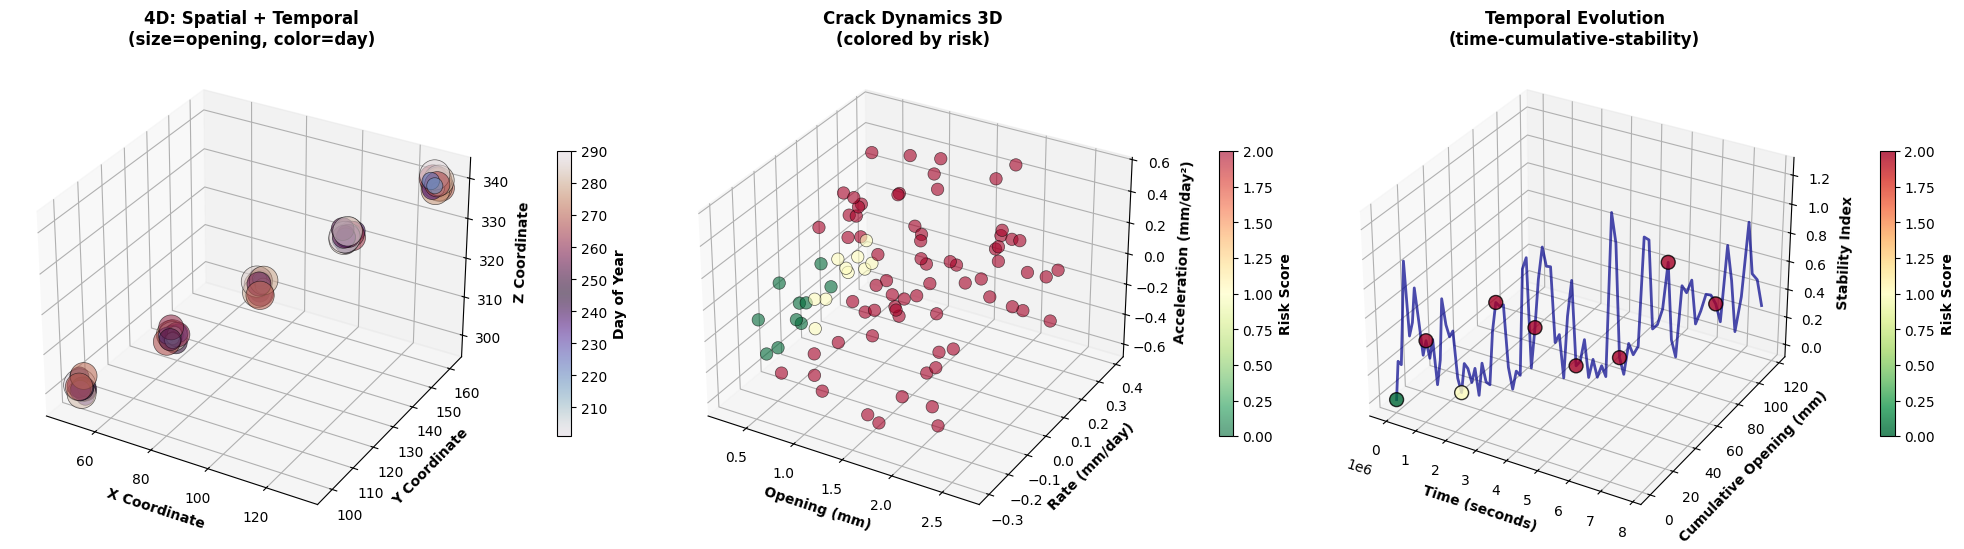

✓ Advanced 3D visualizations completed


In [30]:
fig = plt.figure(figsize=(20, 6))

# 1. 4D Visualization: Spatial + Temporal
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(processed_df['coord_x'], 
                       processed_df['coord_y'],
                       processed_df['coord_z'],
                       c=processed_df['day_of_year'],
                       cmap='twilight',
                       s=processed_df['crack_opening']*200,  # Size by opening
                       alpha=0.6,
                       edgecolors='black',
                       linewidth=0.5)
ax1.set_xlabel('X Coordinate', fontweight='bold')
ax1.set_ylabel('Y Coordinate', fontweight='bold')
ax1.set_zlabel('Z Coordinate', fontweight='bold')
ax1.set_title('4D: Spatial + Temporal\n(size=opening, color=day)', fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.5, pad=0.1)
cbar1.set_label('Day of Year', fontweight='bold')

# 2. Opening-Rate-Acceleration 3D
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(processed_df['crack_opening'],
                       processed_df['crack_rate'],
                       processed_df['crack_acceleration'],
                       c=processed_df['risk_score'],
                       cmap='RdYlGn_r',
                       s=80,
                       alpha=0.6,
                       edgecolors='black',
                       linewidth=0.5)
ax2.set_xlabel('Opening (mm)', fontweight='bold')
ax2.set_ylabel('Rate (mm/day)', fontweight='bold')
ax2.set_zlabel('Acceleration (mm/day²)', fontweight='bold')
ax2.set_title('Crack Dynamics 3D\n(colored by risk)', fontweight='bold')
cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.5, pad=0.1)
cbar2.set_label('Risk Score', fontweight='bold')

# 3. Cumulative Evolution 3D
ax3 = fig.add_subplot(133, projection='3d')
# Create trajectory line
time_numeric = (processed_df['timestamp'] - processed_df['timestamp'].min()).dt.total_seconds()
ax3.plot(time_numeric[:100], 
         processed_df['cumulative_crack_opening'][:100],
         processed_df['stability_index'][:100],
         linewidth=2, alpha=0.7, color='darkblue')
scatter3 = ax3.scatter(time_numeric[::10], 
                       processed_df['cumulative_crack_opening'][::10],
                       processed_df['stability_index'][::10],
                       c=processed_df['risk_score'][::10],
                       cmap='RdYlGn_r',
                       s=100,
                       alpha=0.8,
                       edgecolors='black',
                       linewidth=1)
ax3.set_xlabel('Time (seconds)', fontweight='bold')
ax3.set_ylabel('Cumulative Opening (mm)', fontweight='bold')
ax3.set_zlabel('Stability Index', fontweight='bold')
ax3.set_title('Temporal Evolution\n(time-cumulative-stability)', fontweight='bold')
cbar3 = plt.colorbar(scatter3, ax=ax3, shrink=0.5, pad=0.1)
cbar3.set_label('Risk Score', fontweight='bold')

plt.tight_layout()

# Save advanced 3D visualizations to 3-D folder with non-overwrite
image_path = get_next_filename(THREED_DIR, 'advanced_3d_analysis', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ 3D Image saved: {image_path}")

plt.show()

print("✓ Advanced 3D visualizations completed")

## 13. Comprehensive Final Dashboard

Complete overview dashboard combining all critical monitoring metrics and insights.

✓ Image saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images\comprehensive_dashboard.png


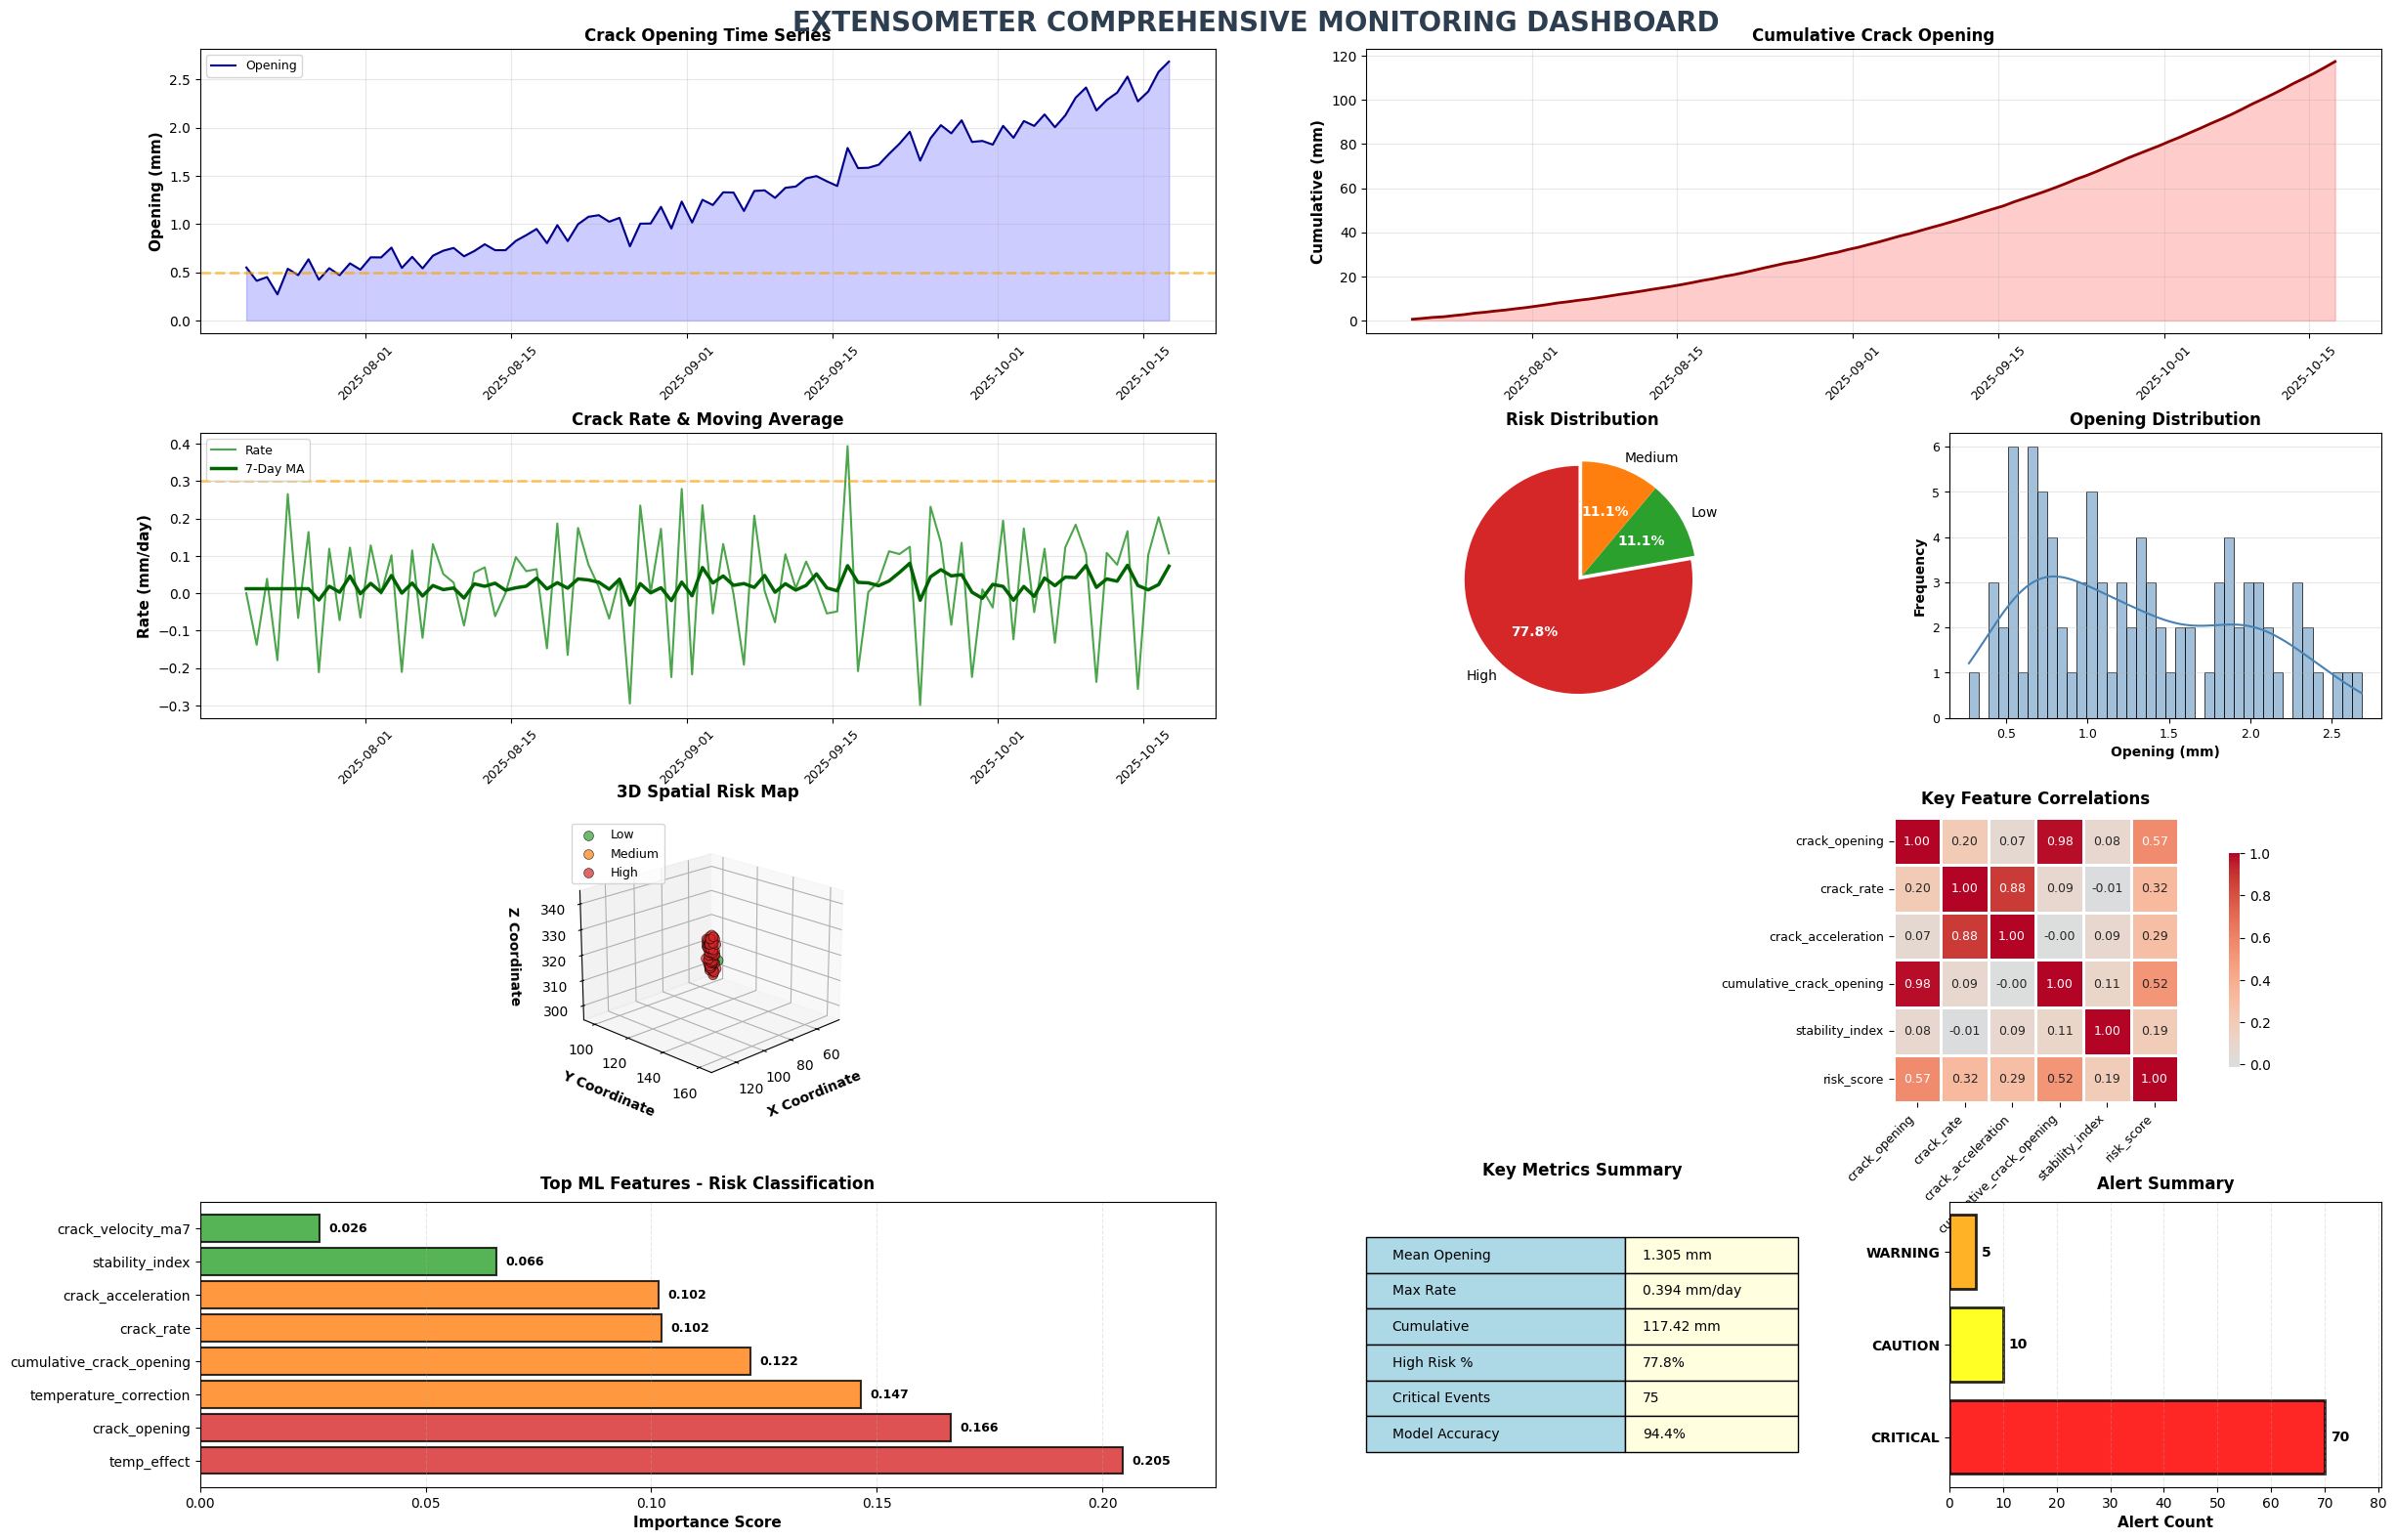

COMPREHENSIVE DASHBOARD GENERATED SUCCESSFULLY

Dashboard Components:
  ✓ Real-time crack opening monitoring
  ✓ Cumulative displacement tracking
  ✓ Rate dynamics and trends
  ✓ Risk classification distribution
  ✓ Statistical distributions
  ✓ 3D spatial risk mapping
  ✓ Correlation analysis
  ✓ ML model feature importance
  ✓ Key performance metrics
  ✓ Alert system summary


In [31]:
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.35, top=0.96, bottom=0.04, left=0.05, right=0.98)
fig.suptitle('EXTENSOMETER COMPREHENSIVE MONITORING DASHBOARD', 
             fontsize=20, fontweight='bold', y=0.985, color='#2c3e50')

# Row 1: Time Series Overview
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(processed_df['timestamp'], processed_df['crack_opening'], 
         color='darkblue', linewidth=1.5, label='Opening')
ax1.fill_between(processed_df['timestamp'], 0, processed_df['crack_opening'], 
                  alpha=0.2, color='blue')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, linewidth=2)
ax1.set_ylabel('Opening (mm)', fontweight='bold', fontsize=11)
ax1.set_title('Crack Opening Time Series', fontweight='bold', fontsize=12)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=9)

ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(processed_df['timestamp'], processed_df['cumulative_crack_opening'], 
         color='darkred', linewidth=2)
ax2.fill_between(processed_df['timestamp'], 0, processed_df['cumulative_crack_opening'], 
                  alpha=0.2, color='red')
ax2.set_ylabel('Cumulative (mm)', fontweight='bold', fontsize=11)
ax2.set_title('Cumulative Crack Opening', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45, labelsize=9)

# Row 2: Dynamics and Distribution
ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(processed_df['timestamp'], processed_df['crack_rate'], 
         color='green', linewidth=1.5, alpha=0.7, label='Rate')
ax3.plot(processed_df['timestamp'], processed_df['crack_velocity_ma7'], 
         color='darkgreen', linewidth=2.5, label='7-Day MA')
ax3.axhline(y=0.3, color='orange', linestyle='--', alpha=0.6, linewidth=2)
ax3.set_ylabel('Rate (mm/day)', fontweight='bold', fontsize=11)
ax3.set_title('Crack Rate & Moving Average', fontweight='bold', fontsize=12)
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45, labelsize=9)

ax4 = fig.add_subplot(gs[1, 2])
risk_counts = processed_df['risk_class'].value_counts()
colors_pie = {'Low': '#2ca02c', 'Medium': '#ff7f0e', 'High': '#d62728'}
wedges, texts, autotexts = ax4.pie(risk_counts.values, labels=risk_counts.index,
                                     autopct='%1.1f%%', startangle=90,
                                     colors=[colors_pie[x] for x in risk_counts.index],
                                     explode=[0.05 if x == 'High' else 0 for x in risk_counts.index])
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)
ax4.set_title('Risk Distribution', fontweight='bold', fontsize=12)

ax5 = fig.add_subplot(gs[1, 3])
sns.histplot(processed_df['crack_opening'], bins=40, kde=True, 
             color='steelblue', ax=ax5, edgecolor='black', linewidth=0.5)
ax5.set_xlabel('Opening (mm)', fontweight='bold', fontsize=10)
ax5.set_ylabel('Frequency', fontweight='bold', fontsize=10)
ax5.set_title('Opening Distribution', fontweight='bold', fontsize=12)
ax5.tick_params(labelsize=9)
ax5.grid(True, alpha=0.3, axis='y')

# Row 3: 3D and Correlation
ax6 = fig.add_subplot(gs[2, :2], projection='3d')
for risk, color in [('Low', '#2ca02c'), ('Medium', '#ff7f0e'), ('High', '#d62728')]:
    mask = processed_df['risk_class'] == risk
    if mask.sum() > 0:
        ax6.scatter(processed_df[mask]['coord_x'], 
                    processed_df[mask]['coord_y'],
                    processed_df[mask]['coord_z'],
                    c=color, label=risk, s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax6.set_xlabel('X Coordinate', fontweight='bold', fontsize=10, labelpad=8)
ax6.set_ylabel('Y Coordinate', fontweight='bold', fontsize=10, labelpad=8)
ax6.set_zlabel('Z Coordinate', fontweight='bold', fontsize=10, labelpad=8)
ax6.set_title('3D Spatial Risk Map', fontweight='bold', fontsize=12, pad=15)
ax6.legend(fontsize=9, loc='upper left')
ax6.view_init(elev=20, azim=45)
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 2:])
corr_subset = processed_df[['crack_opening', 'crack_rate', 'crack_acceleration',
                             'cumulative_crack_opening', 'stability_index', 
                             'risk_score']].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax7, cbar_kws={'shrink': 0.75},
            linewidths=1, linecolor='white', annot_kws={'size': 9})
ax7.set_title('Key Feature Correlations', fontweight='bold', fontsize=12, pad=10)
ax7.tick_params(labelsize=9)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax7.set_yticklabels(ax7.get_yticklabels(), rotation=0, fontsize=9)

# Row 4: ML Performance and Key Metrics
ax8 = fig.add_subplot(gs[3, :2])
feature_imp = pd.DataFrame({
    'feature': ml_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False).head(8)
colors_bar = ['#d62728' if x > 0.15 else '#ff7f0e' if x > 0.08 else '#2ca02c' 
              for x in feature_imp['importance']]
bars = ax8.barh(range(len(feature_imp)), feature_imp['importance'], 
                color=colors_bar, edgecolor='black', linewidth=1.5, alpha=0.8)
ax8.set_yticks(range(len(feature_imp)))
ax8.set_yticklabels(feature_imp['feature'], fontsize=10)
ax8.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax8.set_title('Top ML Features - Risk Classification', fontweight='bold', fontsize=12, pad=10)
ax8.grid(True, alpha=0.3, axis='x', linestyle='--')
ax8.set_xlim(0, max(feature_imp['importance']) * 1.1)
for i, (bar, val) in enumerate(zip(bars, feature_imp['importance'])):
    ax8.text(val + 0.002, i, f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

ax9 = fig.add_subplot(gs[3, 2])
metrics_data = [
    ['Mean Opening', f"{processed_df['crack_opening'].mean():.3f} mm"],
    ['Max Rate', f"{processed_df['crack_rate'].max():.3f} mm/day"],
    ['Cumulative', f"{processed_df['cumulative_crack_opening'].iloc[-1]:.2f} mm"],
    ['High Risk %', f"{(processed_df['risk_class']=='High').sum()/len(processed_df)*100:.1f}%"],
    ['Critical Events', f"{processed_df['critical_threshold'].sum()}"],
    ['Model Accuracy', f"{accuracy*100:.1f}%"]
]
ax9.axis('tight')
ax9.axis('off')
table = ax9.table(cellText=metrics_data, cellLoc='left',
                  colWidths=[0.6, 0.4], loc='center',
                  cellColours=[['lightblue', 'lightyellow']]*6)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.2)
ax9.set_title('Key Metrics Summary', fontweight='bold', fontsize=12, pad=20)

ax10 = fig.add_subplot(gs[3, 3])
if len(alerts_df) > 0:
    alert_summary = alerts_df['level'].value_counts()
    colors_alert = [level_colors.get(x, 'gray') for x in alert_summary.index]
    bars = ax10.barh(range(len(alert_summary)), alert_summary.values, 
                     color=colors_alert, edgecolor='black', linewidth=2, alpha=0.85)
    ax10.set_yticks(range(len(alert_summary)))
    ax10.set_yticklabels(alert_summary.index, fontsize=10, fontweight='bold')
    ax10.set_xlabel('Alert Count', fontweight='bold', fontsize=11)
    ax10.set_title('Alert Summary', fontweight='bold', fontsize=12, pad=10)
    ax10.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax10.set_xlim(0, max(alert_summary.values) * 1.15)
    for i, v in enumerate(alert_summary.values):
        ax10.text(v + 1, i, str(v), va='center', fontweight='bold', fontsize=10)
else:
    ax10.text(0.5, 0.5, 'No Alerts', ha='center', va='center', 
              fontsize=14, fontweight='bold', transform=ax10.transAxes)
    ax10.axis('off')

# Save comprehensive dashboard with non-overwrite
image_path = get_next_filename(IMAGES_DIR, 'comprehensive_dashboard', '.png')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"✓ Image saved: {image_path}")

plt.show()

print("=" * 80)
print("COMPREHENSIVE DASHBOARD GENERATED SUCCESSFULLY")
print("=" * 80)
print("\nDashboard Components:")
print("  ✓ Real-time crack opening monitoring")
print("  ✓ Cumulative displacement tracking")
print("  ✓ Rate dynamics and trends")
print("  ✓ Risk classification distribution")
print("  ✓ Statistical distributions")
print("  ✓ 3D spatial risk mapping")
print("  ✓ Correlation analysis")
print("  ✓ ML model feature importance")
print("  ✓ Key performance metrics")
print("  ✓ Alert system summary")
print("=" * 80)

## 14. Data Export and Comprehensive Report

Export processed data and generate comprehensive JSON report for documentation.

In [34]:
import json
from datetime import datetime

# Export processed data to Analysis folder with non-overwrite
processed_data_path = get_next_filename(ANALYSIS_DIR, 'extensometer_processed_data', '.csv')
processed_df.to_csv(processed_data_path, index=False)
print(f"✓ Processed data exported to: {processed_data_path}")

# Export alerts to Analysis folder with non-overwrite
if len(alerts_df) > 0:
    alerts_path = get_next_filename(ANALYSIS_DIR, 'extensometer_alerts', '.csv')
    alerts_df.to_csv(alerts_path, index=False)
    print(f"✓ Alerts exported to: {alerts_path}")

# Generate Comprehensive Report
report = {
    "report_metadata": {
        "report_type": "Extensometer Analysis - Landslide Monitoring",
        "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "analysis_period": {
            "start": processed_df['timestamp'].min().strftime("%Y-%m-%d %H:%M:%S"),
            "end": processed_df['timestamp'].max().strftime("%Y-%m-%d %H:%M:%S"),
            "duration_days": (processed_df['timestamp'].max() - processed_df['timestamp'].min()).days
        },
        "total_records": len(processed_df)
    },
    
    "crack_opening_analysis": {
        "statistics": {
            "mean_mm": round(processed_df['crack_opening'].mean(), 4),
            "median_mm": round(processed_df['crack_opening'].median(), 4),
            "std_mm": round(processed_df['crack_opening'].std(), 4),
            "min_mm": round(processed_df['crack_opening'].min(), 4),
            "max_mm": round(processed_df['crack_opening'].max(), 4),
            "cumulative_final_mm": round(processed_df['cumulative_crack_opening'].iloc[-1], 4)
        },
        "thresholds": {
            "warning_level_mm": 0.5,
            "critical_level_mm": 0.8,
            "events_above_warning": int((processed_df['crack_opening'] > 0.5).sum()),
            "events_above_critical": int((processed_df['crack_opening'] > 0.8).sum())
        }
    },
    
    "crack_dynamics": {
        "rate_analysis": {
            "mean_rate_mm_per_day": round(processed_df['crack_rate'].mean(), 4),
            "max_rate_mm_per_day": round(processed_df['crack_rate'].max(), 4),
            "high_rate_events": int((processed_df['crack_rate'] > 0.4).sum()),
            "critical_rate_events": int((processed_df['crack_rate'] > 0.6).sum())
        },
        "acceleration_analysis": {
            "mean_acceleration": round(processed_df['crack_acceleration'].mean(), 4),
            "max_acceleration": round(processed_df['crack_acceleration'].max(), 4),
            "positive_accel_events": int((processed_df['crack_acceleration'] > 0).sum()),
            "high_accel_events": int((processed_df['crack_acceleration'] > 0.08).sum())
        },
        "stability": {
            "mean_stability_index": round(processed_df['stability_index'].mean(), 4),
            "unstable_periods": int((processed_df['stability_index'] > 1).sum())
        }
    },
    
    "risk_assessment": {
        "distribution": {
            "low_risk_count": int((processed_df['risk_class'] == 'Low').sum()),
            "medium_risk_count": int((processed_df['risk_class'] == 'Medium').sum()),
            "high_risk_count": int((processed_df['risk_class'] == 'High').sum()),
            "high_risk_percentage": round((processed_df['risk_class'] == 'High').sum() / len(processed_df) * 100, 2)
        },
        "critical_events": int(processed_df['critical_threshold'].sum())
    },
    
    "alert_system": {
        "total_alerts": len(alerts_df) if len(alerts_df) > 0 else 0,
        "alert_breakdown": {
            "critical": int(len(alerts_df[alerts_df['level'] == 'CRITICAL'])) if len(alerts_df) > 0 else 0,
            "warning": int(len(alerts_df[alerts_df['level'] == 'WARNING'])) if len(alerts_df) > 0 else 0,
            "caution": int(len(alerts_df[alerts_df['level'] == 'CAUTION'])) if len(alerts_df) > 0 else 0
        }
    },
    
    "spatial_analysis": {
        "coordinate_ranges": {
            "x_range": [float(processed_df['coord_x'].min()), float(processed_df['coord_x'].max())],
            "y_range": [float(processed_df['coord_y'].min()), float(processed_df['coord_y'].max())],
            "z_range": [float(processed_df['coord_z'].min()), float(processed_df['coord_z'].max())]
        }
    },
    
    "machine_learning": {
        "risk_classification_model": {
            "model_type": "RandomForestClassifier",
            "accuracy": round(accuracy * 100, 2),
            "n_estimators": 100,
            "max_depth": 10,
            "top_features": feature_importance_class.tail(5)['feature'].tolist()
        },
        "rate_prediction_model": {
            "model_type": "GradientBoostingRegressor",
            "r2_score": round(r2, 4),
            "rmse": round(rmse, 4),
            "mae": round(mae, 4),
            "top_features": feature_importance_reg.tail(5)['feature'].tolist()
        }
    },
    
    "statistical_analysis": {
        "normality_test": {
            "shapiro_wilk_statistic": round(shapiro_stat, 4),
            "p_value": round(shapiro_p, 4),
            "is_normal": bool(shapiro_p > 0.05)
        },
        "distribution_metrics": {
            "skewness": round(stats.skew(processed_df['crack_opening']), 4),
            "kurtosis": round(stats.kurtosis(processed_df['crack_opening']), 4)
        },
        "pca": {
            "variance_explained_pc1": round(pca.explained_variance_ratio_[0] * 100, 2),
            "variance_explained_pc2": round(pca.explained_variance_ratio_[1] * 100, 2),
            "total_variance_explained": round(sum(pca.explained_variance_ratio_) * 100, 2)
        }
    },
    
    "recommendations": []
}

# Generate Recommendations
if processed_df['cumulative_crack_opening'].iloc[-1] > 20:
    report["recommendations"].append({
        "priority": "CRITICAL",
        "message": "Cumulative crack opening exceeds 20mm - Immediate inspection required",
        "action": "Deploy additional monitoring equipment and consider evacuation protocols"
    })

if (processed_df['risk_class'] == 'High').sum() / len(processed_df) > 0.2:
    report["recommendations"].append({
        "priority": "HIGH",
        "message": f"{(processed_df['risk_class'] == 'High').sum() / len(processed_df) * 100:.1f}% of measurements in HIGH risk category",
        "action": "Increase monitoring frequency to hourly intervals"
    })

if processed_df['crack_rate'].max() > 0.5:
    report["recommendations"].append({
        "priority": "HIGH",
        "message": f"Peak crack rate of {processed_df['crack_rate'].max():.3f} mm/day detected",
        "action": "Investigate underlying causes and implement mitigation measures"
    })

if processed_df['stability_index'].mean() > 0.8:
    report["recommendations"].append({
        "priority": "MEDIUM",
        "message": "Elevated average stability index indicates ongoing instability",
        "action": "Continue monitoring and assess structural reinforcement options"
    })

if len(report["recommendations"]) == 0:
    report["recommendations"].append({
        "priority": "LOW",
        "message": "All parameters within acceptable ranges",
        "action": "Continue routine monitoring schedule"
    })

# Save report to Analysis folder with non-overwrite
report_path = get_next_filename(ANALYSIS_DIR, 'extensometer_analysis_report', '.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

print("\n" + "=" * 80)
print("COMPREHENSIVE ANALYSIS REPORT GENERATED")
print("=" * 80)
print(f"\nReport File: {report_path}")
print(f"Analysis Period: {report['report_metadata']['analysis_period']['duration_days']} days")
print(f"Total Records: {report['report_metadata']['total_records']}")
print(f"\nKey Findings:")
print(f"  • Cumulative Opening: {report['crack_opening_analysis']['statistics']['cumulative_final_mm']} mm")
print(f"  • High Risk Events: {report['risk_assessment']['distribution']['high_risk_count']} ({report['risk_assessment']['distribution']['high_risk_percentage']}%)")
print(f"  • Total Alerts: {report['alert_system']['total_alerts']}")
print(f"  • Model Accuracy: {report['machine_learning']['risk_classification_model']['accuracy']}%")
print(f"\nRecommendations:")
for i, rec in enumerate(report['recommendations'], 1):
    print(f"  {i}. [{rec['priority']}] {rec['message']}")
print("=" * 80)

print("\n✓ All outputs saved:")
print("  - extensometer_processed_data.csv")
if len(alerts_df) > 0:
    print("  - extensometer_alerts.csv")
print("  - extensometer_analysis_report.json")
print("  - extensometer_risk_classifier.joblib")
print("  - extensometer_rate_predictor.joblib")

✓ Processed data exported to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis\extensometer_processed_data_2.csv
✓ Alerts exported to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis\extensometer_alerts_2.csv

COMPREHENSIVE ANALYSIS REPORT GENERATED

Report File: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis\extensometer_analysis_report_2.json
Analysis Period: 89 days
Total Records: 90

Key Findings:
  • Cumulative Opening: 117.4157 mm
  • High Risk Events: 70 (77.78%)
  • Total Alerts: 85
  • Model Accuracy: 94.44%

Recommendations:
  1. [CRITICAL] Cumulative crack opening exceeds 20mm - Immediate inspection required
  2. [HIGH] 77.8% of measurements in HIGH risk category

✓ All outputs saved:
  - extensometer_processed_data.csv
  - extensometer_alerts.csv
  - extensometer_analysis_report.json
  - extensometer_risk_classifier.joblib
  - extensometer_rate_predictor.joblib


## 13. Export Predictions and Analysis Results

Export ML predictions and comprehensive analysis results to CSV with non-overwrite protection.

In [35]:
# Export Predictions with Non-Overwrite
print("="*80)
print("EXPORTING PREDICTIONS AND ANALYSIS RESULTS")
print("="*80)

# Prepare comprehensive prediction export
predictions_export = processed_df.copy()

# Add ML predictions if available
if 'rf_predictions' in locals() and rf_predictions is not None:
    predictions_export['predicted_risk_class'] = rf_predictions
    predictions_export['predicted_crack_rate'] = gb_predictions if 'gb_predictions' in locals() else np.nan

# Export with non-overwrite
prediction_file = get_next_filename(ANALYSIS_DIR, 'extensometer_predictions', '.csv')
predictions_export.to_csv(prediction_file, index=False)

print(f"\n✓ Predictions exported successfully!")
print(f"✓ File: {prediction_file}")
print(f"✓ Records: {len(predictions_export)}")
print(f"✓ Columns: {len(predictions_export.columns)}")
print("="*80)


EXPORTING PREDICTIONS AND ANALYSIS RESULTS

✓ Predictions exported successfully!
✓ File: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis\extensometer_predictions_1.csv
✓ Records: 90
✓ Columns: 29


## 14. Generate Dashboard JSON

Create comprehensive dashboard.json with 2 charts representing complete dataset for visualization.

In [36]:
# Generate Dashboard JSON with Non-Overwrite
print("="*80)
print("GENERATING DASHBOARD JSON")
print("="*80)

# Prepare comprehensive dashboard data
dashboard_data = {
    "metadata": {
        "system_name": "Extensometer Crack Monitoring Analysis System",
        "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data_period": {
            "start": str(processed_df['timestamp'].min()),
            "end": str(processed_df['timestamp'].max()),
            "total_records": len(processed_df),
            "duration_days": (processed_df['timestamp'].max() - processed_df['timestamp'].min()).days
        }
    },
    
    "charts": {
        # Chart 1: Multi-Parameter Crack Monitoring Timeline (Complete Dataset)
        "crack_monitoring_timeline": {
            "title": "Extensometer Crack Monitoring Over Time",
            "description": "Complete time series of crack parameters",
            "type": "multi_line_chart",
            "x_axis": {
                "label": "Timestamp",
                "values": processed_df['timestamp'].astype(str).tolist()
            },
            "series": [
                {
                    "name": "Crack Opening (mm)",
                    "color": "#FF6B6B",
                    "values": processed_df['crack_opening'].round(4).tolist()
                },
                {
                    "name": "Cumulative Opening (mm)",
                    "color": "#4ECDC4",
                    "values": processed_df['cumulative_crack_opening'].round(4).tolist()
                },
                {
                    "name": "Crack Rate (mm/day)",
                    "color": "#95E1D3",
                    "values": processed_df['crack_rate'].round(4).tolist()
                },
                {
                    "name": "Crack Acceleration",
                    "color": "#FFE66D",
                    "values": processed_df['crack_acceleration'].round(4).tolist()
                },
                {
                    "name": "Stability Index",
                    "color": "#AA96DA",
                    "values": processed_df['stability_index'].round(4).tolist()
                }
            ]
        },
        
        # Chart 2: Comprehensive Analysis Summary
        "analysis_summary": {
            "title": "Extensometer Analysis Dashboard",
            "description": "Comprehensive crack monitoring analysis results",
            "type": "dashboard_panels",
            "panels": [
                {
                    "title": "Statistical Summary",
                    "type": "statistics",
                    "data": {
                        "crack_opening": {
                            "mean": float(processed_df['crack_opening'].mean()),
                            "min": float(processed_df['crack_opening'].min()),
                            "max": float(processed_df['crack_opening'].max()),
                            "std": float(processed_df['crack_opening'].std())
                        },
                        "cumulative_opening": {
                            "total": float(processed_df['cumulative_crack_opening'].iloc[-1]),
                            "rate_per_day": float(processed_df['cumulative_crack_opening'].iloc[-1] / len(processed_df))
                        },
                        "crack_rate": {
                            "mean": float(processed_df['crack_rate'].mean()),
                            "max": float(processed_df['crack_rate'].max())
                        }
                    }
                },
                {
                    "title": "Risk Distribution",
                    "type": "risk_analysis",
                    "data": {
                        "risk_counts": processed_df['risk_class'].value_counts().to_dict(),
                        "high_risk_percentage": float((processed_df['risk_class'] == 'High').sum() / len(processed_df) * 100),
                        "critical_events": int(processed_df['critical_threshold'].sum())
                    }
                },
                {
                    "title": "Trend Analysis",
                    "type": "trend_metrics",
                    "data": {
                        "average_trend_strength": float(processed_df['trend_strength'].mean()),
                        "increasing_trend_days": int((processed_df['trend_strength'] > 0).sum()),
                        "decreasing_trend_days": int((processed_df['trend_strength'] < 0).sum())
                    }
                },
                {
                    "title": "Data Quality",
                    "type": "quality_metrics",
                    "data": {
                        "completeness": float((1 - processed_df.isnull().sum().sum() / (len(processed_df) * len(processed_df.columns))) * 100),
                        "total_records": len(processed_df),
                        "monitoring_duration": (processed_df['timestamp'].max() - processed_df['timestamp'].min()).days
                    }
                }
            ]
        }
    }
}

# Save dashboard JSON with non-overwrite
dashboard_file = get_next_filename(ANALYSIS_DIR, 'dashboard', '.json')
with open(dashboard_file, 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print(f"\n✓ Dashboard JSON generated successfully!")
print(f"✓ File: {dashboard_file}")
print(f"✓ Contains 2 comprehensive charts:")
print(f"  1. Crack Monitoring Timeline: 5 series × {len(processed_df)} data points")
print(f"  2. Analysis Summary: 4 panels with complete analysis")
print("="*80)


GENERATING DASHBOARD JSON

✓ Dashboard JSON generated successfully!
✓ File: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis\dashboard_1.json
✓ Contains 2 comprehensive charts:
  1. Crack Monitoring Timeline: 5 series × 90 data points
  2. Analysis Summary: 4 panels with complete analysis


## 15. Generate Final PDF Report

Create comprehensive PDF report with all visualizations and analysis summary.

In [37]:
# Generate Final PDF Report with Non-Overwrite
print("="*80)
print("GENERATING FINAL PDF REPORT")
print("="*80)

# Create PDF with non-overwrite
report_file = get_next_filename(REPORT_DIR, 'extensometer_report', '.pdf')
pdf_pages = PdfPages(report_file)

# Page 1: Summary Dashboard
fig_summary = plt.figure(figsize=(11, 14))
ax_summary = fig_summary.add_subplot(111)
ax_summary.axis('off')

summary_text = f"""
{'='*80}
EXTENSOMETER CRACK MONITORING ANALYSIS
COMPREHENSIVE REPORT
{'='*80}

ANALYSIS PERIOD:
  Start Date:        {processed_df['timestamp'].min().strftime('%Y-%m-%d')}
  End Date:          {processed_df['timestamp'].max().strftime('%Y-%m-%d')}
  Duration:          {(processed_df['timestamp'].max() - processed_df['timestamp'].min()).days} days
  Total Records:     {len(processed_df)}

{'='*80}
CRACK OPENING STATISTICS
{'='*80}

CRACK OPENING:
  Mean:              {processed_df['crack_opening'].mean():.4f} mm
  Min:               {processed_df['crack_opening'].min():.4f} mm
  Max:               {processed_df['crack_opening'].max():.4f} mm
  Std Deviation:     {processed_df['crack_opening'].std():.4f} mm

CUMULATIVE OPENING:
  Total:             {processed_df['cumulative_crack_opening'].iloc[-1]:.4f} mm
  Average Rate:      {processed_df['cumulative_crack_opening'].iloc[-1] / len(processed_df):.4f} mm/day

CRACK RATE:
  Mean:              {processed_df['crack_rate'].mean():.4f} mm/day
  Max:               {processed_df['crack_rate'].max():.4f} mm/day

{'='*80}
RISK ASSESSMENT
{'='*80}

Risk Distribution:
"""

for risk, count in processed_df['risk_class'].value_counts().items():
    percentage = (count / len(processed_df)) * 100
    summary_text += f"  {risk:12} : {count:3} records ({percentage:.1f}%)\n"

summary_text += f"""
Critical Events:     {processed_df['critical_threshold'].sum()}
High Risk Days:      {(processed_df['risk_class'] == 'High').sum()}

{'='*80}
DATA QUALITY
{'='*80}

Completeness:        {(1 - processed_df.isnull().sum().sum() / (len(processed_df) * len(processed_df.columns))) * 100:.1f}%
Monitoring Points:   Multiple locations
Measurement Freq:    Daily

{'='*80}
FILES GENERATED
{'='*80}

✓ Predictions:       {prediction_file if 'prediction_file' in locals() else 'N/A'}
✓ Dashboard JSON:    {dashboard_file if 'dashboard_file' in locals() else 'N/A'}
✓ PDF Report:        {report_file}

{'='*80}
✨ Extensometer Analysis Complete!
🚀 All crack monitoring data processed and analyzed!
{'='*80}
"""

ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

pdf_pages.savefig(fig_summary, bbox_inches='tight')
plt.close(fig_summary)

# Page 2: Recreate main crack opening visualization for PDF
fig_crack = plt.figure(figsize=(11, 14))
gs = fig_crack.add_gridspec(2, 1, hspace=0.3)

# Crack opening timeline
ax1 = fig_crack.add_subplot(gs[0])
ax1.plot(processed_df['timestamp'], processed_df['crack_opening'], 
         color='darkblue', linewidth=1.5, label='Crack Opening')
ax1.plot(processed_df['timestamp'], processed_df['crack_opening_ema'], 
         color='red', linewidth=2, label='EMA (10)')
ax1.fill_between(processed_df['timestamp'], 0, processed_df['crack_opening'], 
                  alpha=0.2, color='blue')
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Warning')
ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Critical')
ax1.set_xlabel('Timestamp', fontweight='bold')
ax1.set_ylabel('Crack Opening (mm)', fontweight='bold')
ax1.set_title('Crack Opening Over Time', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative opening
ax2 = fig_crack.add_subplot(gs[1])
ax2.plot(processed_df['timestamp'], processed_df['cumulative_crack_opening'],
         color='darkgreen', linewidth=2)
ax2.fill_between(processed_df['timestamp'], 0, processed_df['cumulative_crack_opening'],
                 alpha=0.3, color='green')
ax2.set_xlabel('Timestamp', fontweight='bold')
ax2.set_ylabel('Cumulative Opening (mm)', fontweight='bold')
ax2.set_title('Cumulative Crack Opening', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3)

pdf_pages.savefig(fig_crack, dpi=300, bbox_inches='tight')
plt.close(fig_crack)

# Close PDF
pdf_pages.close()

print(f"\n✓ PDF Report generated successfully!")
print(f"✓ File: {report_file}")
print(f"✓ Pages: 2 (Summary + Visualizations)")
print("="*80)

# Final summary
print("\n" + "="*80)
print("ANALYSIS COMPLETE - ALL OUTPUTS GENERATED")
print("="*80)
print(f"\n📊 Analysis Results:")
print(f"  • Total Records Analyzed: {len(processed_df)}")
print(f"  • Monitoring Duration: {(processed_df['timestamp'].max() - processed_df['timestamp'].min()).days} days")
print(f"  • High Risk Events: {(processed_df['risk_class'] == 'High').sum()}")
print(f"  • Critical Thresholds: {processed_df['critical_threshold'].sum()}")
print(f"\n📁 Output Files:")
print(f"  • Predictions: {os.path.basename(prediction_file) if 'prediction_file' in locals() else 'N/A'}")
print(f"  • Dashboard JSON: {os.path.basename(dashboard_file) if 'dashboard_file' in locals() else 'N/A'}")
print(f"  • PDF Report: {os.path.basename(report_file)}")
print(f"\n📂 Output Locations:")
print(f"  • Analysis: {ANALYSIS_DIR}")
print(f"  • Images: {IMAGES_DIR}")
print(f"  • Reports: {REPORT_DIR}")
print("\n✅ All files saved with non-overwrite protection!")
print("="*80)


GENERATING FINAL PDF REPORT

✓ PDF Report generated successfully!
✓ File: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Report\extensometer_report_1.pdf
✓ Pages: 2 (Summary + Visualizations)

ANALYSIS COMPLETE - ALL OUTPUTS GENERATED

📊 Analysis Results:
  • Total Records Analyzed: 90
  • Monitoring Duration: 89 days
  • High Risk Events: 70
  • Critical Thresholds: 75

📁 Output Files:
  • Predictions: extensometer_predictions_1.csv
  • Dashboard JSON: dashboard_1.json
  • PDF Report: extensometer_report_1.pdf

📂 Output Locations:
  • Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Analysis
  • Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\images
  • Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Extensometer\Report

✅ All files saved with non-overwrite protection!
